In [2]:
import pandas as pd
import math
from unidecode import unidecode
import numpy as np
import scipy.io
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import os


from scipy.stats import linregress

PATH_UPV = "./DatosExperimento1/UPV"
PATH_UGR = "./DatosExperimento1/UGR"

# Leer el archivo Excel en un DataFrame de pandas
df_upv = pd.read_excel(PATH_UPV+'/Exp1_Observadores_UPV.xlsx')
df_ugr = pd.read_excel(PATH_UGR+'/Exp1_Observadores_UGR.xlsx')
    
if not os.path.exists('Resultados_UPV'):
    os.makedirs('Resultados_UPV')    

RESULTS_PATH_UPV = 'Resultados_UPV/0-PROMEDIOS'
if not os.path.exists(RESULTS_PATH_UPV):
    os.makedirs(RESULTS_PATH_UPV)

if not os.path.exists('Resultados_UGR'):
    os.makedirs('Resultados_UGR')
    
RESULTS_PATH_UGR = 'Resultados_UGR/0-PROMEDIOS'
if not os.path.exists(RESULTS_PATH_UGR):
    os.makedirs(RESULTS_PATH_UGR)
    
if not os.path.exists('Resultados_TOTAL'):
    os.makedirs('Resultados_TOTAL')
    
RESULTS_PATH_TOTAL = 'Resultados_TOTAL'

# Array de ficheros .mat, nos da igual el volunatrio
ficheros_upv = []
ficheros_ugr = []
ficheros_total = []

# Iterar sobre cada fila del DataFrame
for idx, row in df_upv.iterrows():
    ficheros_upv.append(row['Fichero'])
    ficheros_total.append(PATH_UPV+"/"+row['Fichero'])
    
for idx, row in df_ugr.iterrows():
    ficheros_ugr.append(row['Fichero'])
    ficheros_total.append(PATH_UGR+"/"+row['Fichero'])

print(ficheros_upv)
print(ficheros_ugr)
print(ficheros_total)

['ResultsJNDsNoiseFlatBG20211129T112353.mat', 'ResultsJNDsNoiseFlatBG20211129T120005.mat', 'ResultsJNDsNoiseFlatBG20211129T133717.mat', 'ResultsJNDsNoiseFlatBG20211129T140322.mat', 'ResultsJNDsNoiseFlatBG20211129T163621.mat', 'ResultsJNDsNoiseFlatBG20211129T171934.mat', 'ResultsJNDsNoiseFlatBG20211130T105700.mat', 'ResultsJNDsNoiseFlatBG20211201T114113.mat', 'ResultsJNDsNoiseFlatBG20211202T140213.mat', 'ResultsJNDsNoiseFlatBG20211202T142641.mat', 'ResultsJNDsNoiseFlatBG20211203T102719.mat', 'ResultsJNDsNoiseFlatBG20211210T101730.mat', 'ResultsJNDsNoiseFlatBG20211210T105955.mat', 'ResultsJNDsNoiseFlatBG20211210T112932.mat', 'ResultsJNDsNoiseFlatBG20211210T120626.mat', 'ResultsJNDsNoiseFlatBG20211210T145230.mat', 'ResultsJNDsNoiseFlatBG20211210T160923.mat', 'ResultsJNDsNoiseFlatBG20211210T163932.mat', 'ResultsJNDsNoiseFlatBG20211217T141916.mat', 'ResultsJNDsNoiseFlatBG20211217T171615.mat', 'ResultsJNDsNoiseFlatBG20211220T112329.mat', 'ResultsJNDsNoiseFlatBG20211222T112032.mat', 'ResultsJ

In [3]:
def normcdf2(x, mu, sigma):
    '''
    Utilizo la función norm.cdf de la librería scipy.stats para calcular la función de distribución acumulada (CDF) 
    de la distribución normal, y luego dividimos el resultado por dos y sumamos 0.5 para ajustar el rango a [0,1].
    '''
    y = (norm.cdf(x, mu, sigma) + 1) / 2
    return y

def normcdf2_minimizer(X, params):
    # X incluye mu y sigma
    mu = X[0]
    sigma = X[1]

    # x/y valores para ajustar
    x = params['x']
    y = params['y']

    # los valores ajustados con mu y sigma dados
    yfit = normcdf2(x, mu, sigma)

    # cálculo del error
    err = np.sum((yfit - y)**2)

    return err

In [4]:
# Variables generales
ruidos = scipy.io.loadmat('ruidosExp1.mat')
ruidos = np.array(ruidos['ruidos'])
minX = np.min(ruidos[:, 2])
maxX = np.max(ruidos[:, 2])
LoopNumber = 16
numberObservations = 10

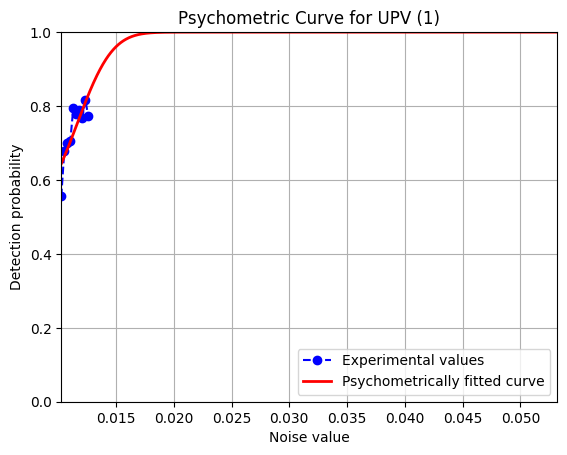

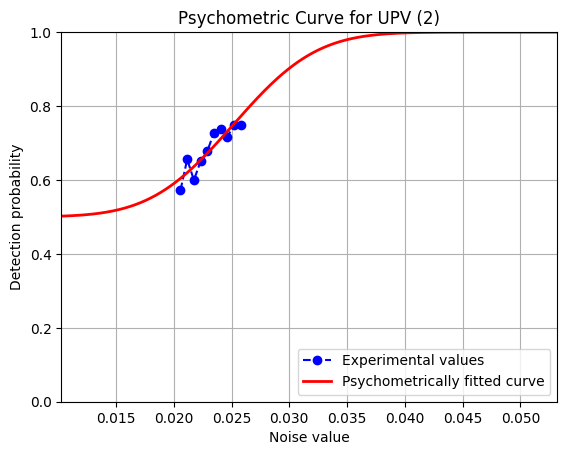

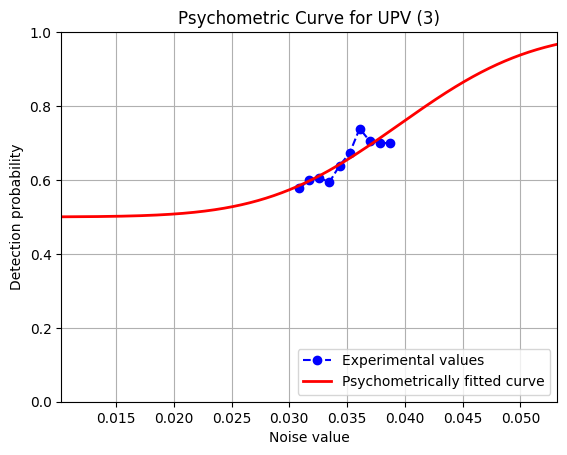

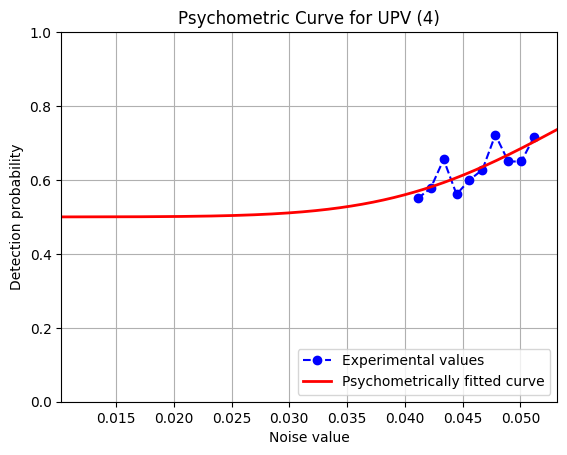

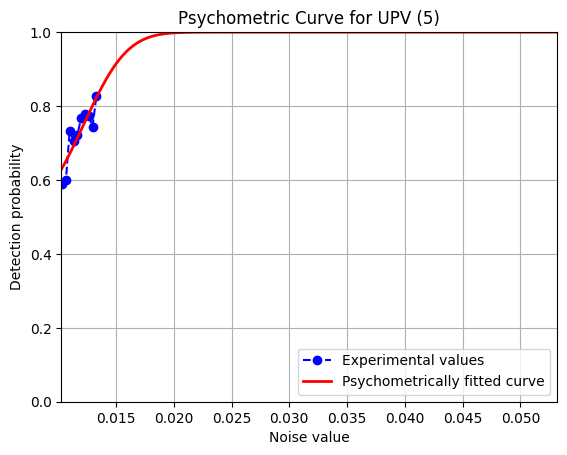

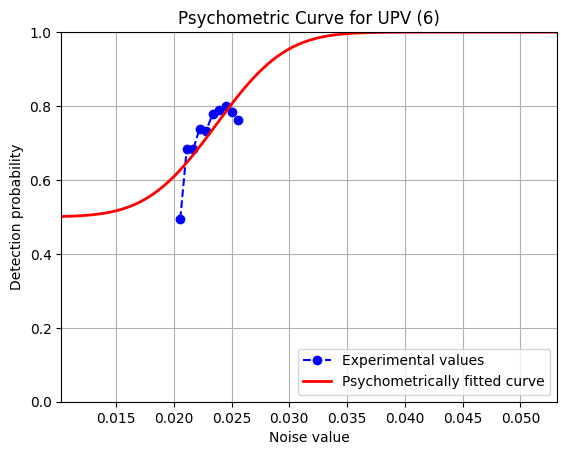

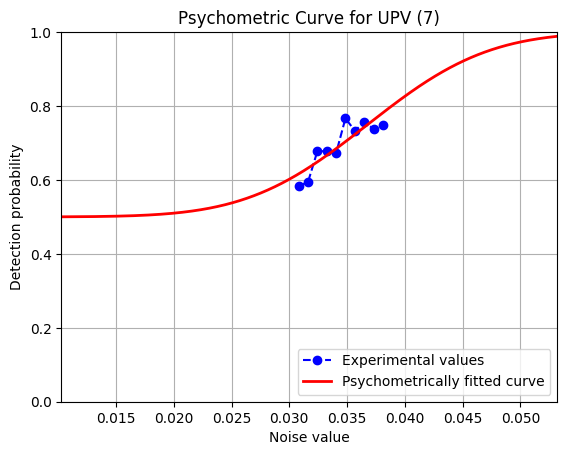

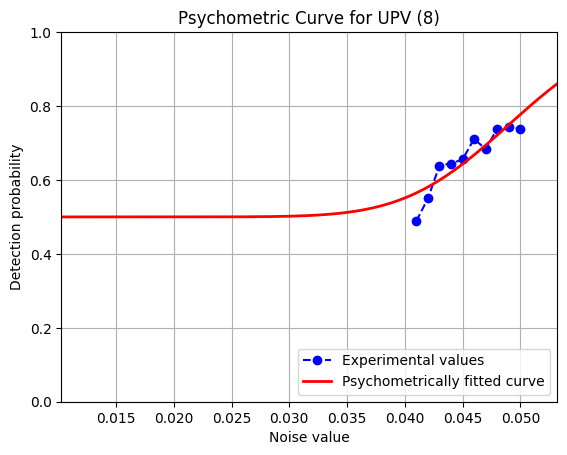

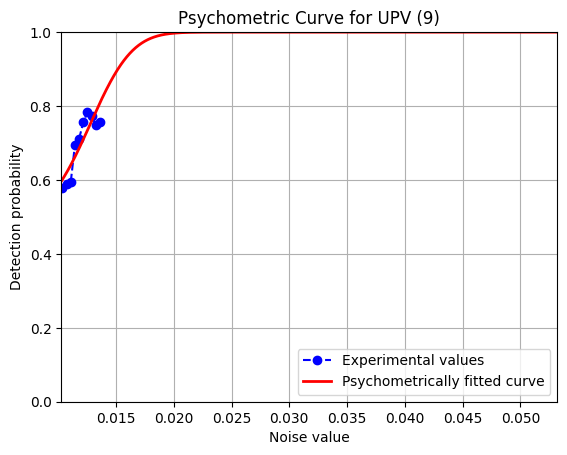

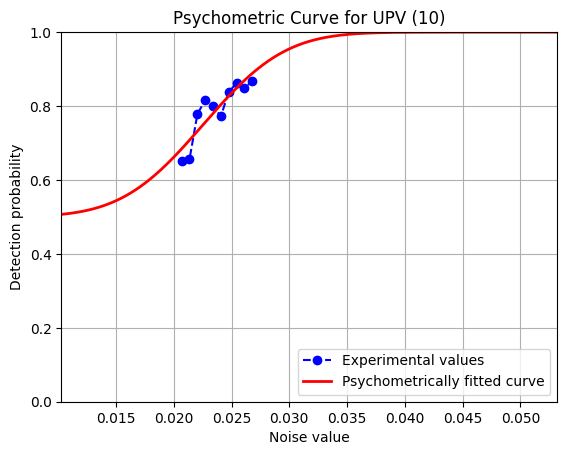

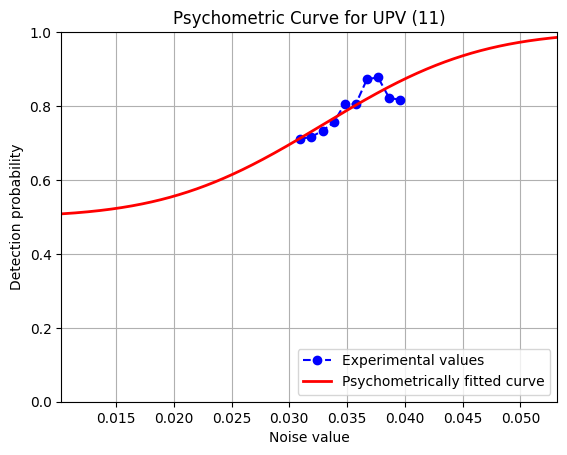

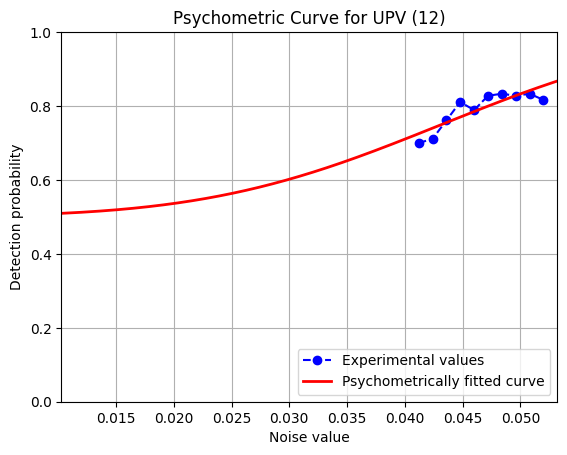

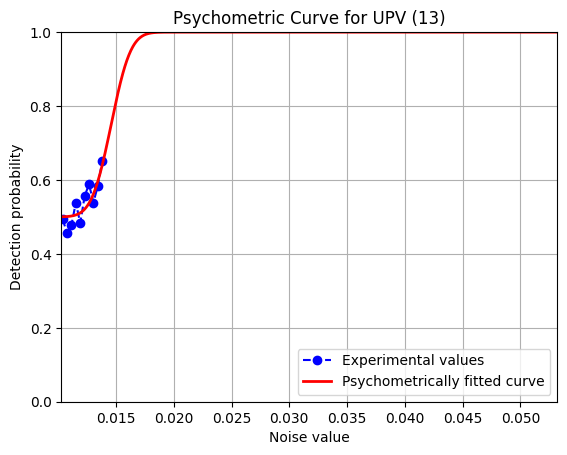

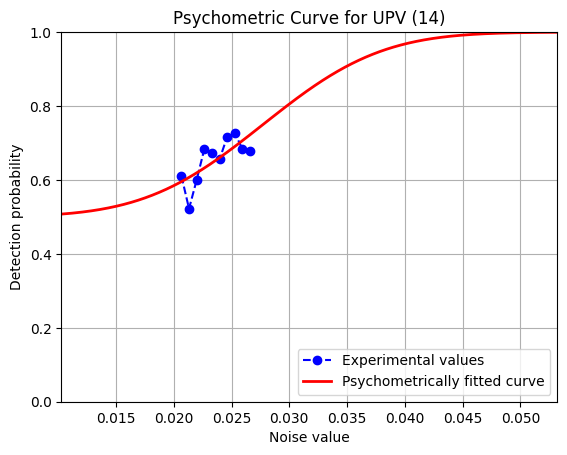

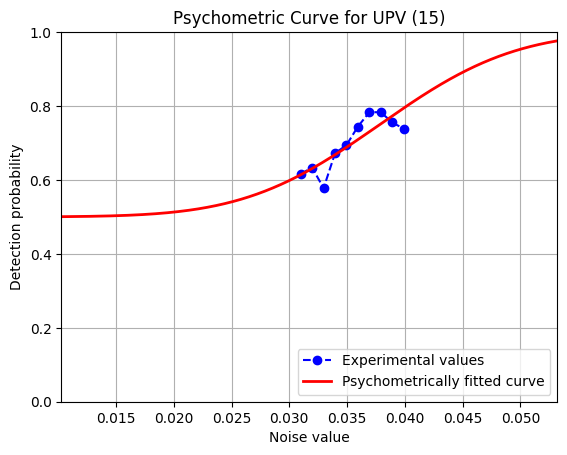

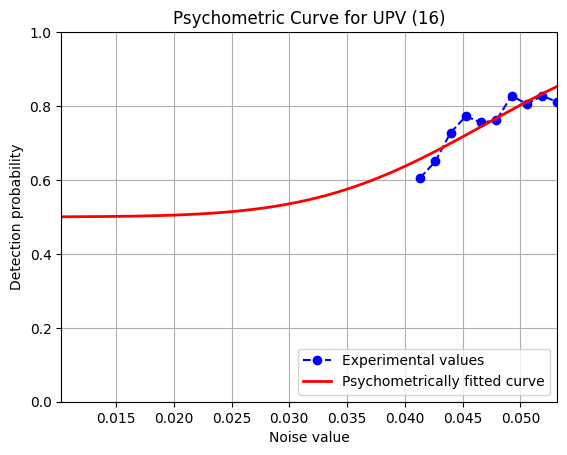

<Figure size 640x480 with 0 Axes>

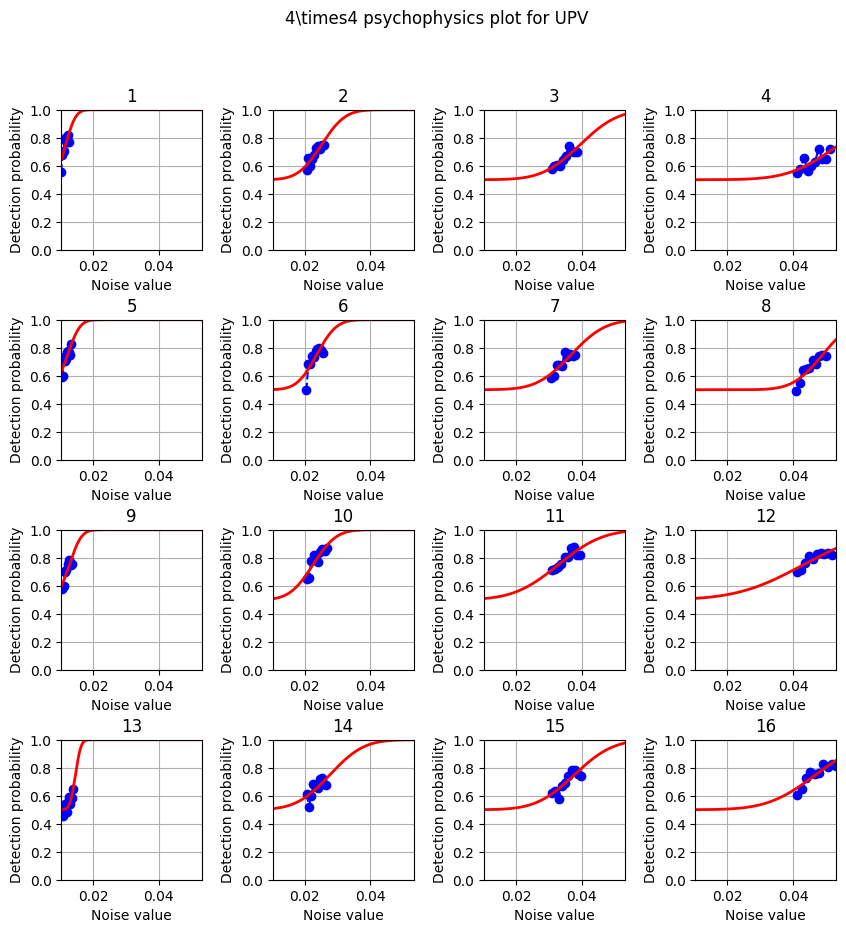

<Figure size 640x480 with 0 Axes>

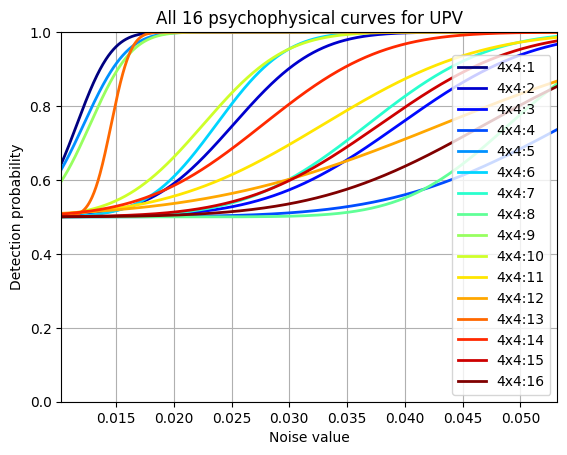

In [5]:
# UPV
mean_result_upv = None
mean_std_upv = []
for fichero in ficheros_upv:
    data_file = PATH_UPV+'/'+fichero
    result = scipy.io.loadmat(data_file)
    result = np.array(result['Results'])
    if mean_result_upv is None:
        mean_result_upv = result
    else:
        mean_result_upv = mean_result_upv + result 
        # Suma de los resultados
        # Promediar la probabilidad y Promediar el tiempo
mean_result_upv = mean_result_upv/len(ficheros_upv) # Media de los resultados para todos los ficheros de la UPV
    
# Individual plot
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    y = mean_result_upv[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # parámetros para el ajuste
    params = {'x': x, 'y': y}

    # minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # media y la desviación estándar de la distribución ajustada
    # Se corresponde al umbral, ruido correspondiente a una prob de detección de 0.75
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    # resultados en gráficos independientes
    plt.figure(i)
    plt.plot(x, y, 'o--b')
    plt.axis([min(x), max(x), 0, 1])
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    plt.plot(x_curve, y_curve, '-r', linewidth=2)
    plt.title('Psychometric Curve for UPV ('+ str(i+1)+")")
    plt.xlabel('Noise value')
    plt.ylabel('Detection probability')
    plt.legend(['Experimental values', 'Psychometrically fitted curve'], loc='lower right')
    plt.grid(True)
    plt.xlim([minX, maxX])
    plt.ylim([0, 1])

    # Guardar el gráfico y los datos en .npy
    plt.savefig(RESULTS_PATH_UPV+'/UPV-plot-' + str(i+1) + '.png')
    np.save(RESULTS_PATH_UPV+'/UPV-MeanStdDistribution-' + str(i+1) + '.npy', meanAndStdDistrib)
    
    plt.show()
    mean_std_upv.append((ruido_base, round(ParamsOpt[0], 6), round(ParamsOpt[1], 6)))


# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_upv[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x, y, 'o--b')
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_title(str(i+1))
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

figure.suptitle('4\\times4 psychophysics plot for UPV')
plt.savefig(RESULTS_PATH_UPV+'/UPV-MosaicWithEqualXAxes-' + str(i+1) + '.png')


# All 16 psychophysical curves

plt.figure() 
cc = plt.get_cmap('jet')(np.linspace(0, 1, 16))

fig, ax = plt.subplots()
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_upv[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, linewidth=2, color=cc[i])
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

ax.set_title('All 16 psychophysical curves for UPV')

Legend = []
for i in range(16):
    Legend.append('4x4:{}'.format(i+1))

ax.legend(Legend)

plt.savefig(RESULTS_PATH_UPV+'/UPV-AllPsychomPlots-' + str(i+1) + '.png')

In [6]:
data_upv = [row for row in [mean_std_upv[i:i+4] for i in range(0, 16, 4)]]
for row in data_upv:
    print(row)
mean_std_upv

[(0.01, 0.011607, 0.002403), (0.02, 0.025164, 0.005649), (0.03, 0.039522, 0.009064), (0.04, 0.053994, 0.011909)]
[(0.01, 0.012196, 0.00296), (0.02, 0.02368, 0.004724), (0.03, 0.036786, 0.008197), (0.04, 0.049028, 0.007125)]
[(0.01, 0.012747, 0.002871), (0.02, 0.022552, 0.005572), (0.03, 0.032933, 0.01064), (0.04, 0.043185, 0.015927)]
[(0.01, 0.014579, 0.001328), (0.02, 0.027725, 0.008075), (0.03, 0.037835, 0.009188), (0.04, 0.046935, 0.011525)]


[(0.01, 0.011607, 0.002403),
 (0.02, 0.025164, 0.005649),
 (0.03, 0.039522, 0.009064),
 (0.04, 0.053994, 0.011909),
 (0.01, 0.012196, 0.00296),
 (0.02, 0.02368, 0.004724),
 (0.03, 0.036786, 0.008197),
 (0.04, 0.049028, 0.007125),
 (0.01, 0.012747, 0.002871),
 (0.02, 0.022552, 0.005572),
 (0.03, 0.032933, 0.01064),
 (0.04, 0.043185, 0.015927),
 (0.01, 0.014579, 0.001328),
 (0.02, 0.027725, 0.008075),
 (0.03, 0.037835, 0.009188),
 (0.04, 0.046935, 0.011525)]

Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9998837285733617


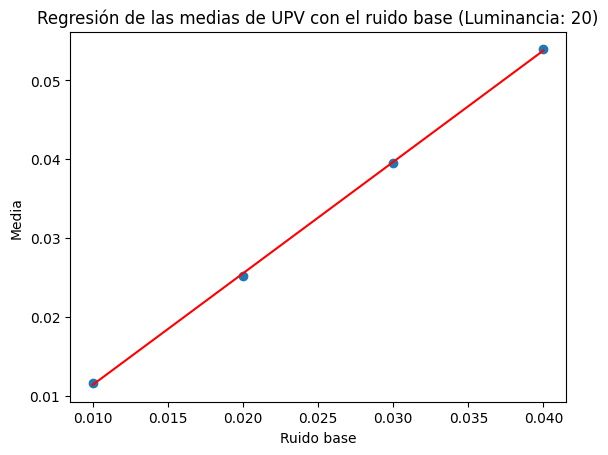

Nivel de Luminancia: 40
Coeficiente de correlación (r): 0.9997038448188796


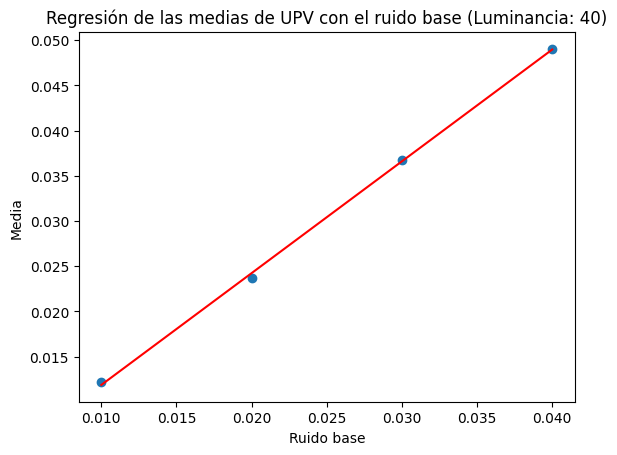

Nivel de Luminancia: 60
Coeficiente de correlación (r): 0.9999276771384522


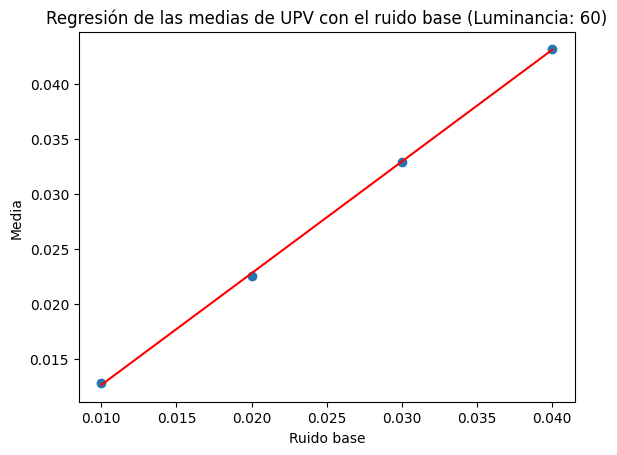

Nivel de Luminancia: 80
Coeficiente de correlación (r): 0.9962794925603862


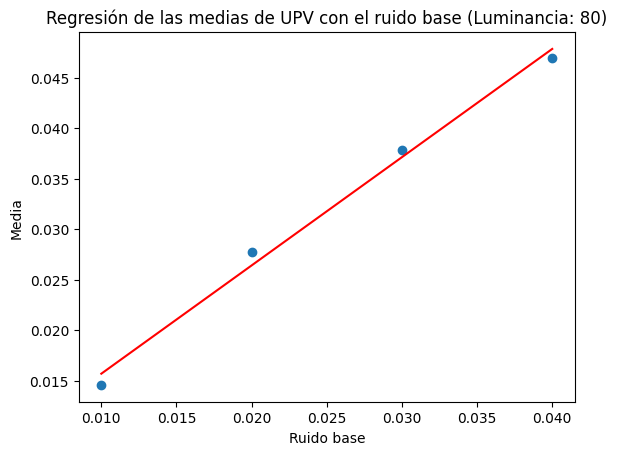

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): 0.9510414513078456


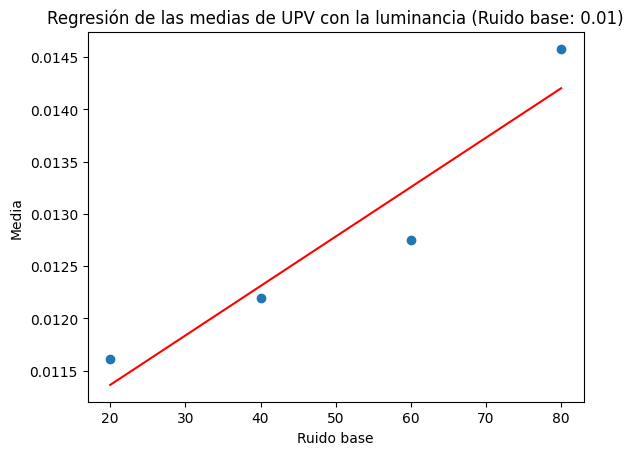

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): 0.37852294853644164


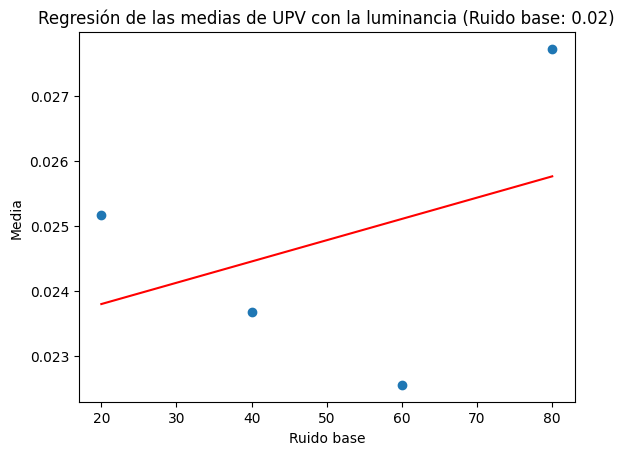

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): -0.41178108189967944


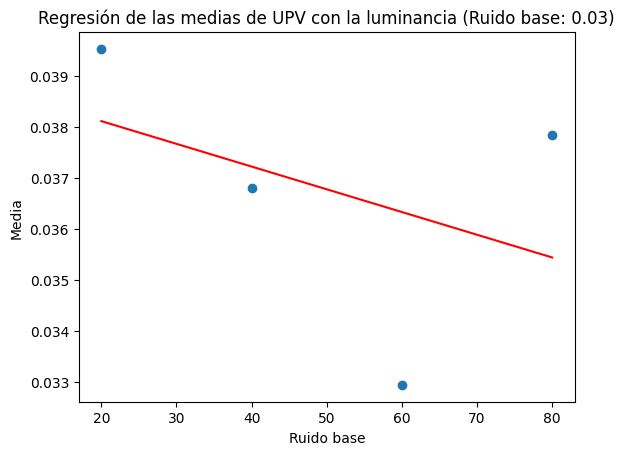

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): -0.7737247769648138


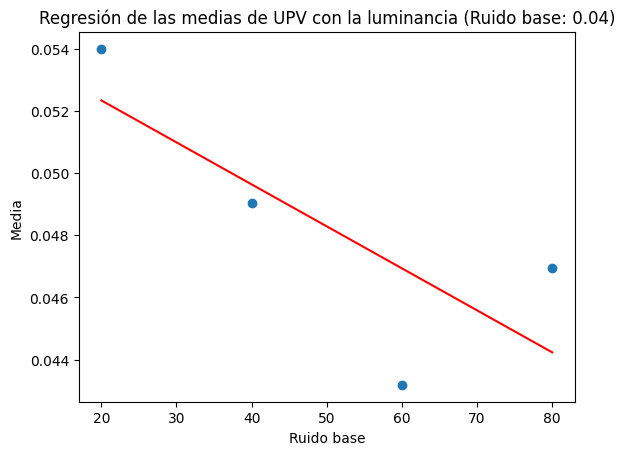

In [7]:
# Regresión de las medias y el ruido base
medias = np.array([i[1] for row in data_upv for i in row])
ruido_base = np.array([i[0] for row in data_upv for i in row])
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_medias = medias[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_medias)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_medias)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de las medias de UPV con el ruido base (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('Media')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_medias = medias[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_medias)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_medias)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de las medias de UPV con la luminancia (Ruido base: {})'.format(ruido))
    plt.xlabel('Ruido base')
    plt.ylabel('Media')
    plt.show()

Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9986516413847398


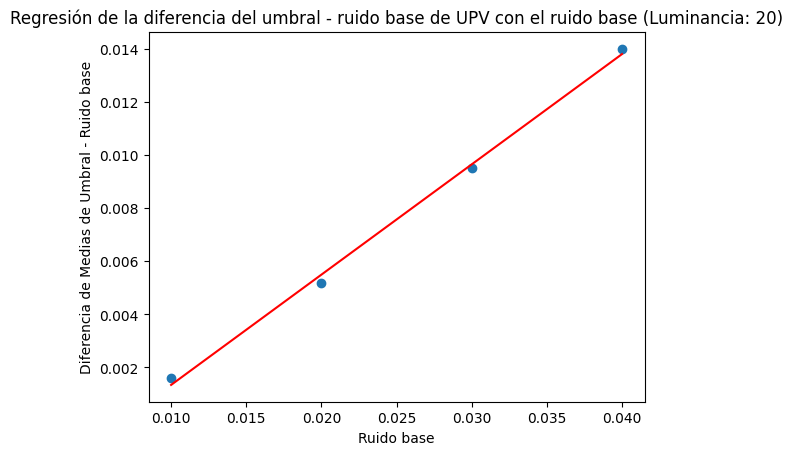

Nivel de Luminancia: 40
Coeficiente de correlación (r): 0.9919719285927342


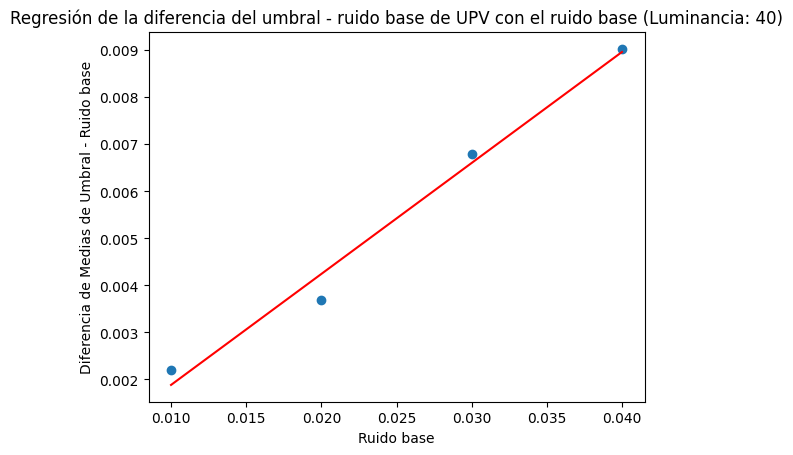

Nivel de Luminancia: 60
Coeficiente de correlación (r): 0.8109124319581814


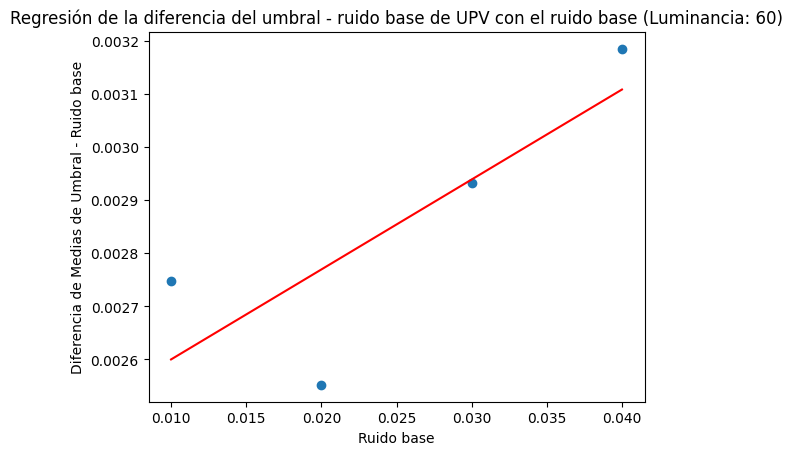

Nivel de Luminancia: 80
Coeficiente de correlación (r): 0.6121887811254693


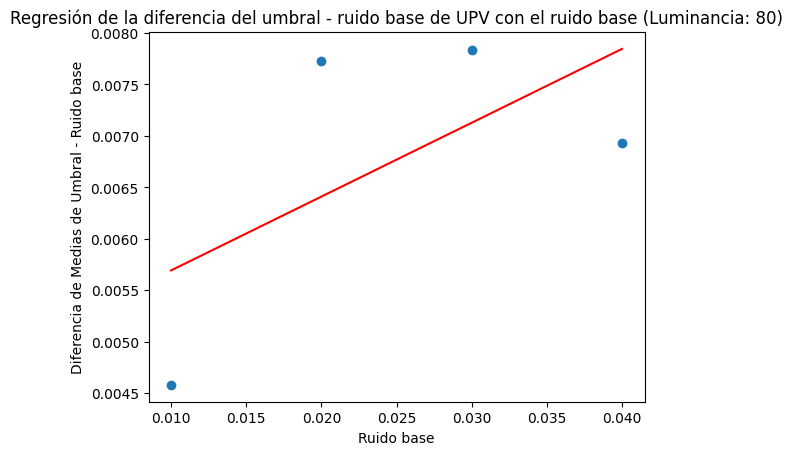

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): 0.9510414513078457


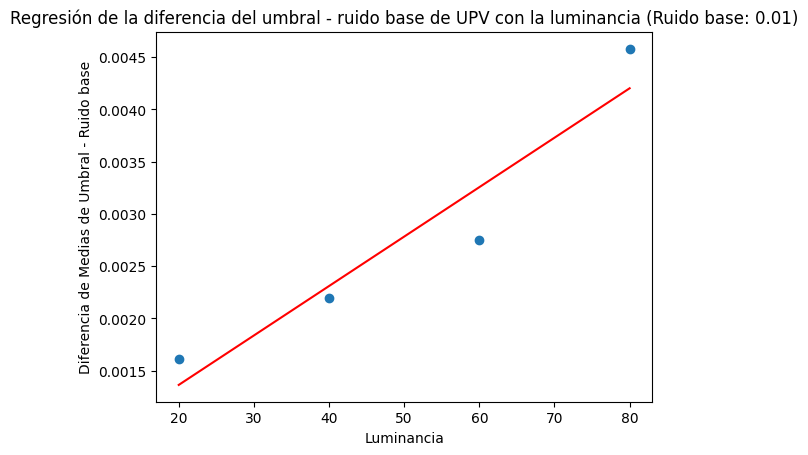

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): 0.37852294853644153


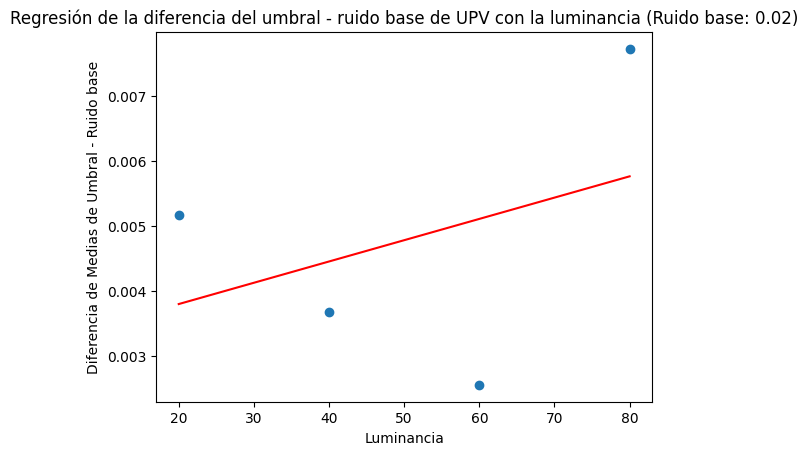

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): -0.41178108189967944


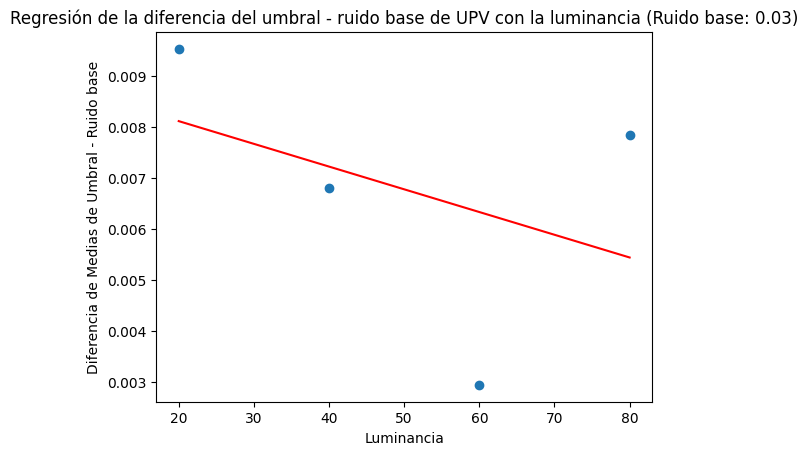

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): -0.7737247769648137


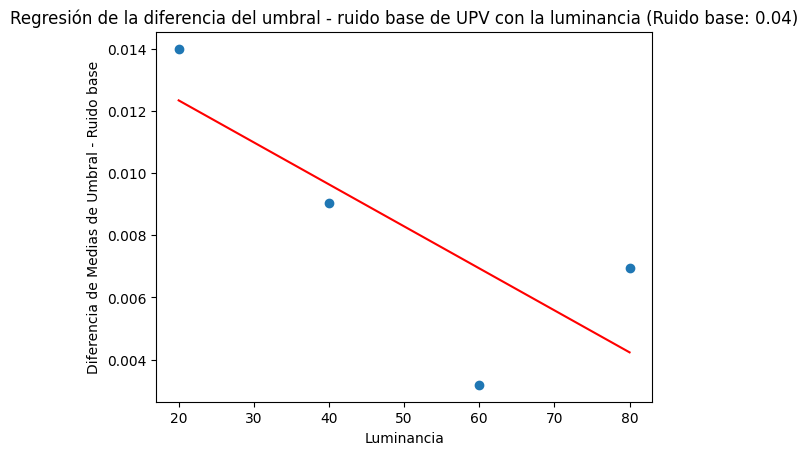

In [8]:
# Regresión de la diferencia del umbral - ruido base y el ruido base

dif_u_r = np.array([i[1]-i[0] for row in data_upv for i in row])
ruido_base = np.array([i[0] for row in data_upv for i in row])
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_diferencias = dif_u_r[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_diferencias)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_diferencias)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de la diferencia del umbral - ruido base de UPV con el ruido base (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('Diferencia de Medias de Umbral - Ruido base')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_diferencias = dif_u_r[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_diferencias)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_diferencias)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de la diferencia del umbral - ruido base de UPV con la luminancia (Ruido base: {})'.format(ruido))
    plt.xlabel('Luminancia')
    plt.ylabel('Diferencia de Medias de Umbral - Ruido base')
    plt.show()

[0.1607     0.2582     0.3174     0.34985    0.2196     0.184
 0.2262     0.2257     0.2747     0.1276     0.09776667 0.079625
 0.4579     0.38625    0.26116667 0.173375  ]
Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9739457509862561


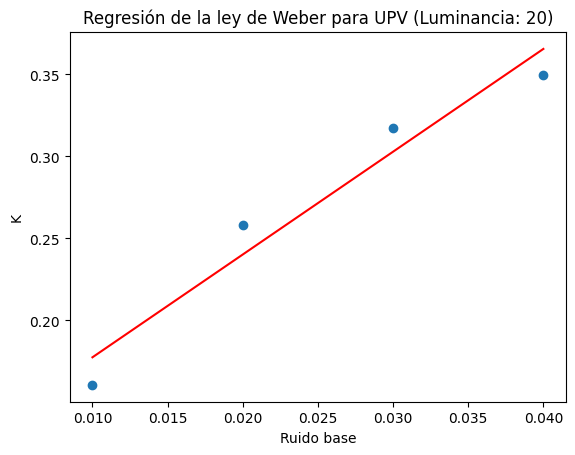

Nivel de Luminancia: 40
Coeficiente de correlación (r): 0.38778426331495985


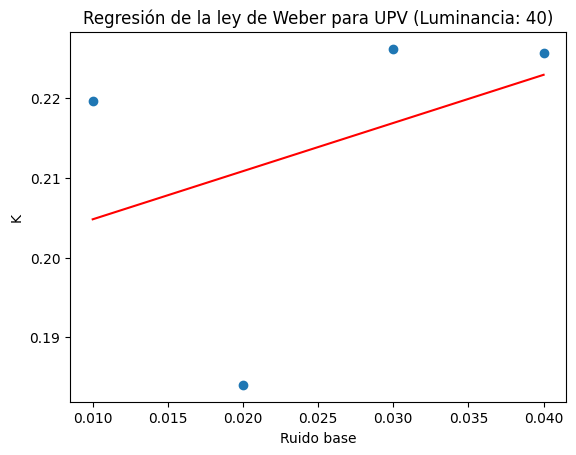

Nivel de Luminancia: 60
Coeficiente de correlación (r): -0.8946891336094643


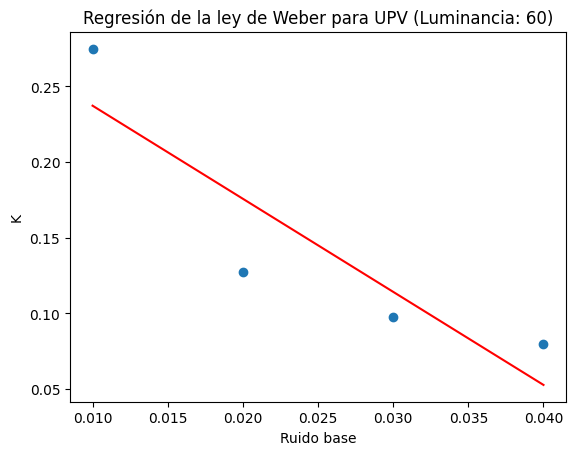

Nivel de Luminancia: 80
Coeficiente de correlación (r): -0.995059783987176


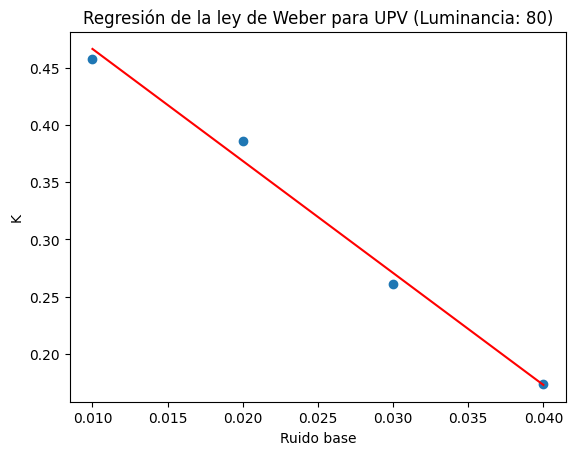

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): 0.9510414513078457


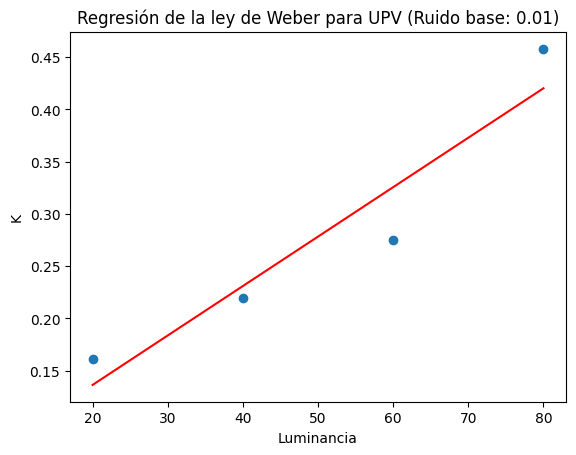

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): 0.3785229485364415


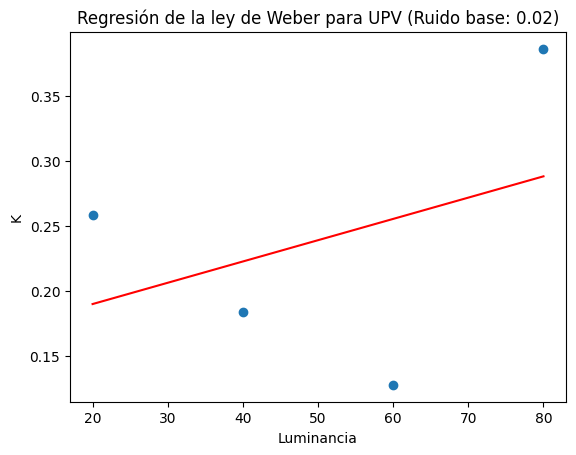

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): -0.4117810818996796


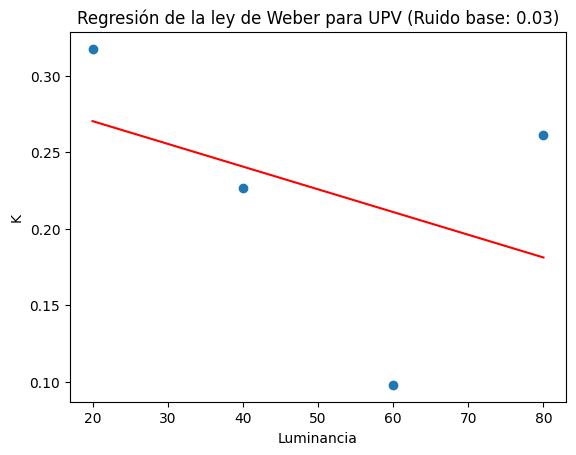

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): -0.7737247769648138


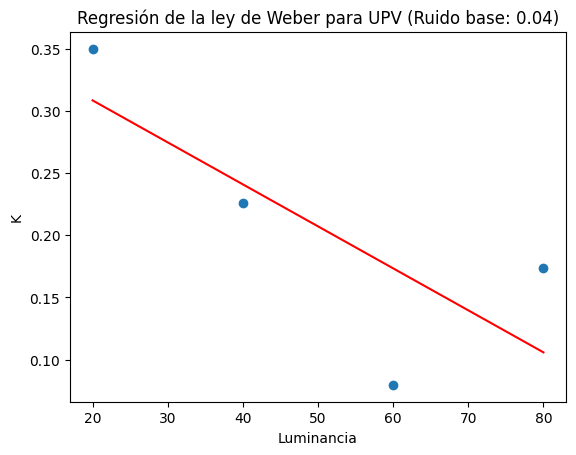

In [9]:
# Ley de Weber UPV

# La diferencia mínima perceptible entre el ruido base y el ruido umbral en cada es cociente %
# (u-r)/r = k
k = np.array([((i[1]-i[0])/i[0]) for row in data_upv for i in row])
print(k)

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_k= k[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_k)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_k)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de la ley de Weber para UPV (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('K')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_k = k[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_k)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_k)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de la ley de Weber para UPV (Ruido base: {})'.format(ruido))
    plt.xlabel('Luminancia')
    plt.ylabel('K')
    plt.show()

Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9993386461846212


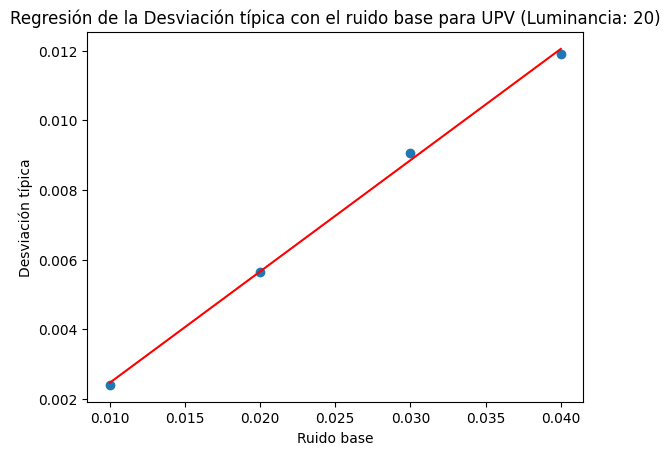

Nivel de Luminancia: 40
Coeficiente de correlación (r): 0.8733327056023187


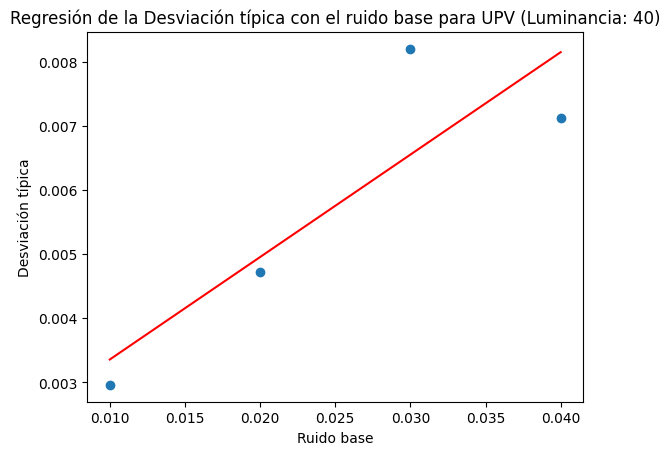

Nivel de Luminancia: 60
Coeficiente de correlación (r): 0.9904169203114628


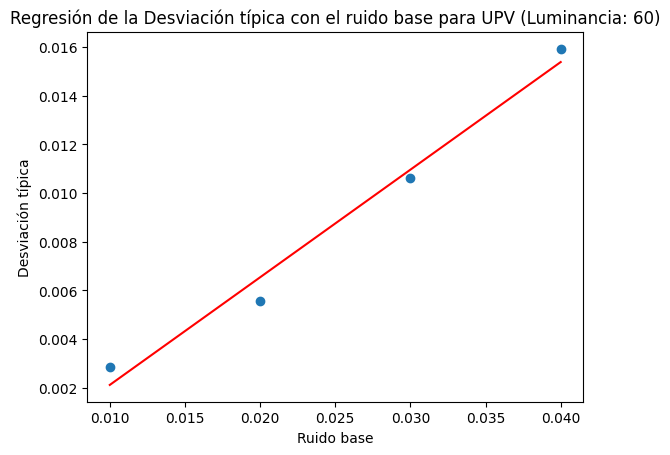

Nivel de Luminancia: 80
Coeficiente de correlación (r): 0.935137315429754


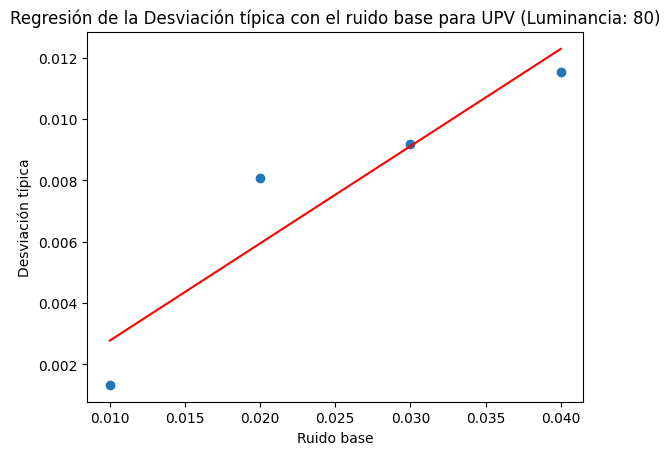

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): -0.5709936295060706


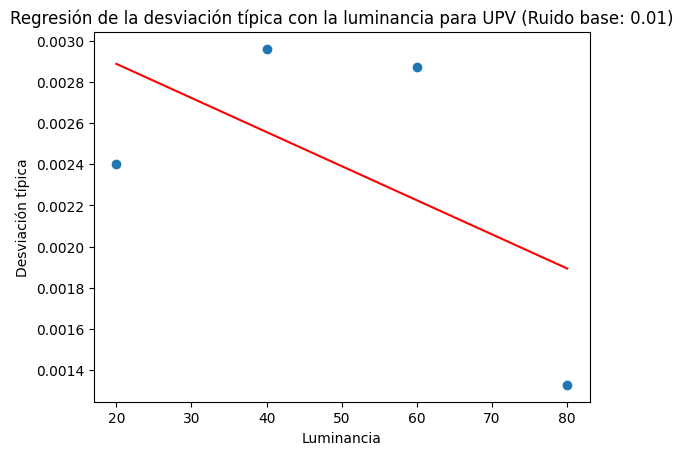

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): 0.7273886708688422


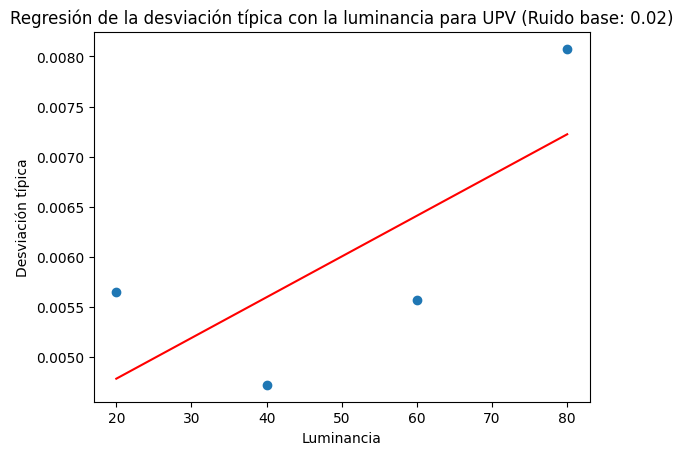

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): 0.35881751297293807


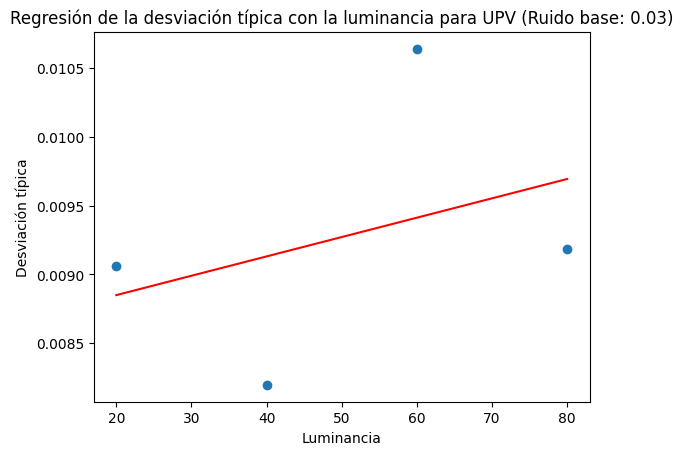

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): 0.2744499533140692


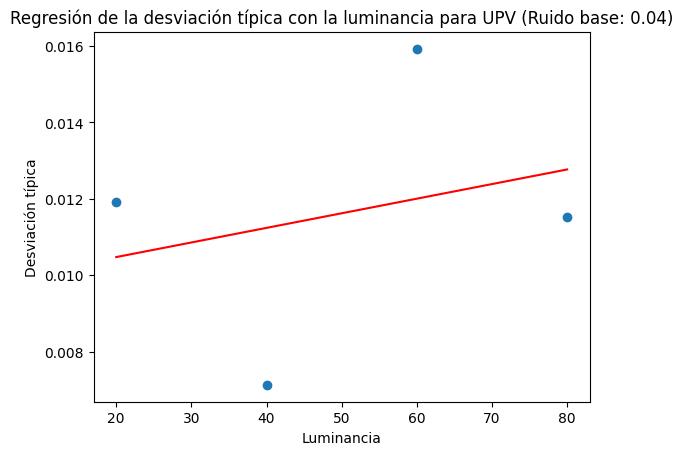

In [10]:
# Regresión de la desviación típica y el ruido base

std = np.array([i[2] for row in data_upv for i in row])
ruido_base = np.array([i[0] for row in data_upv for i in row])
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_std = std[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_std)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_std)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de la Desviación típica con el ruido base para UPV (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('Desviación típica')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_std = std[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_std)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_std)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de la desviación típica con la luminancia para UPV (Ruido base: {})'.format(ruido))
    plt.xlabel('Luminancia')
    plt.ylabel('Desviación típica')
    plt.show()

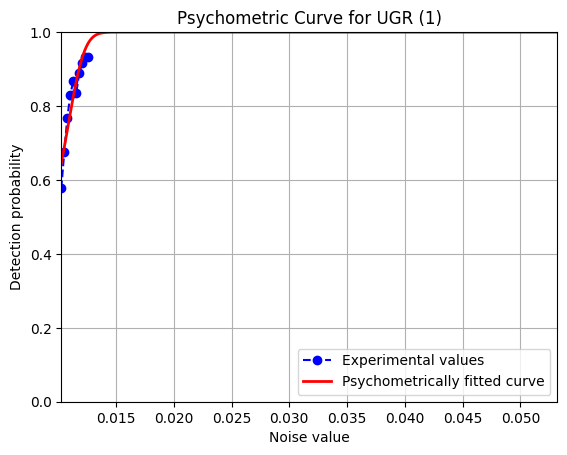

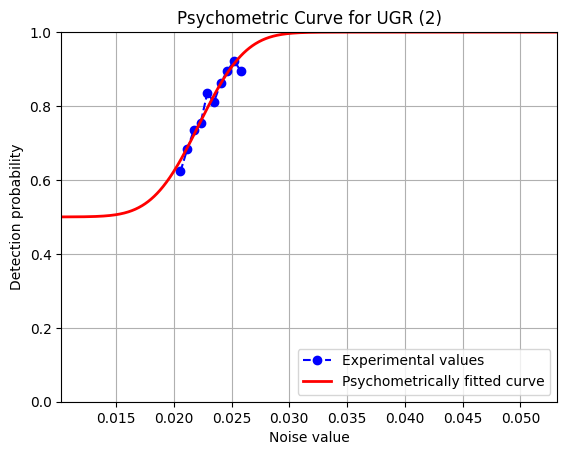

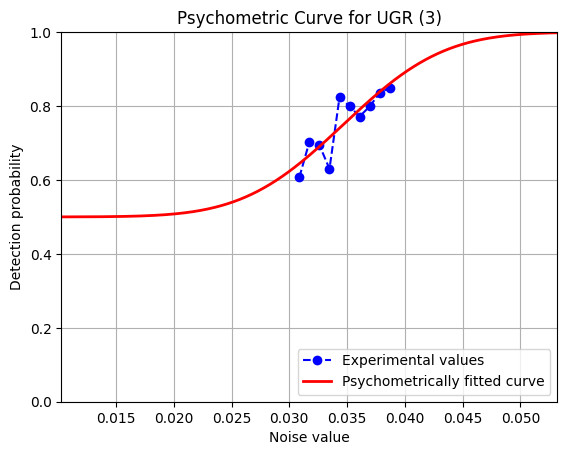

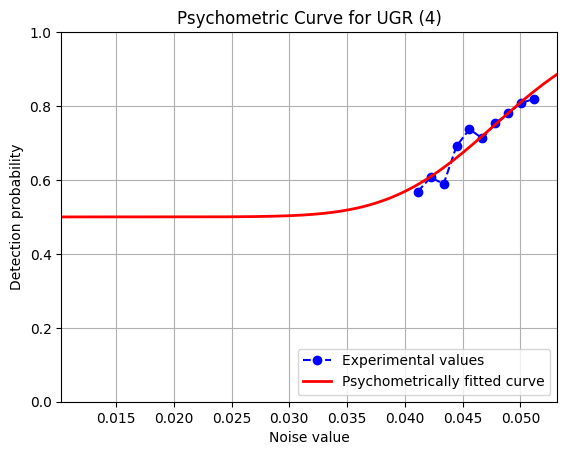

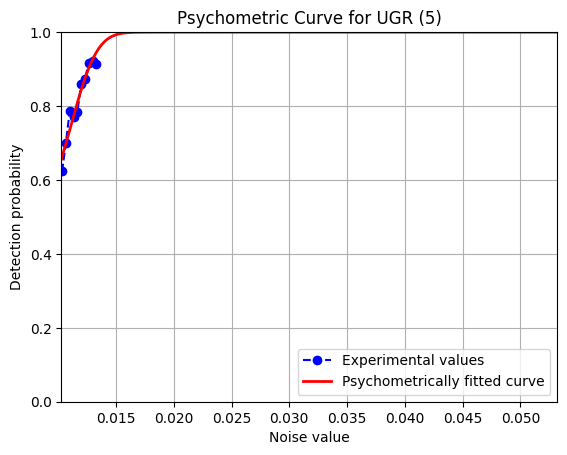

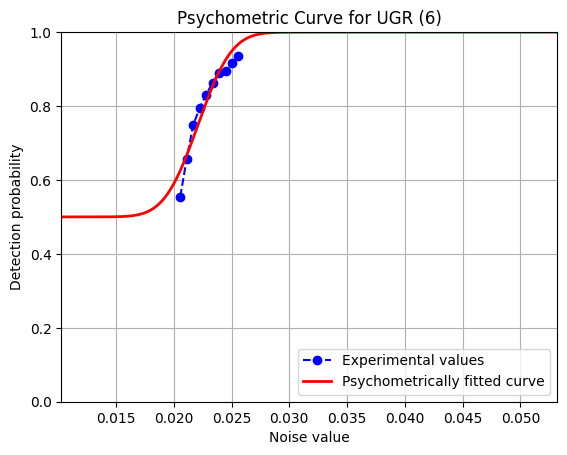

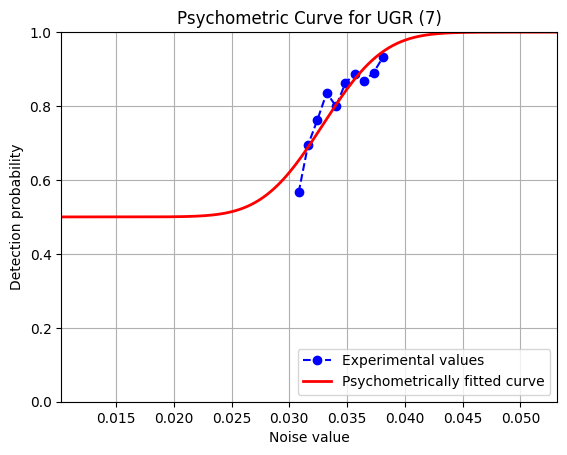

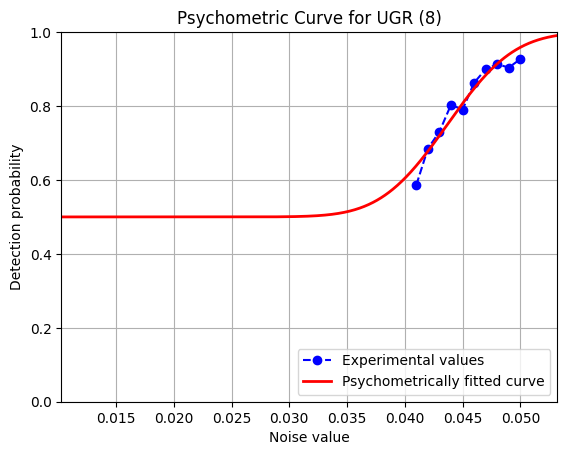

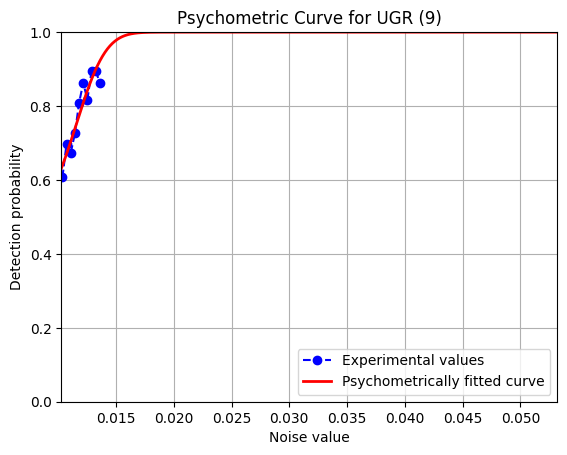

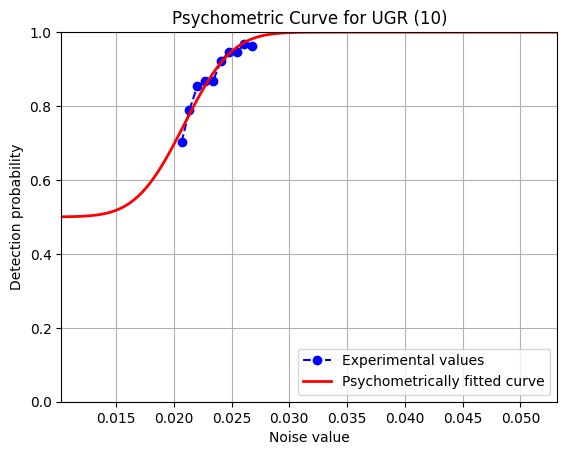

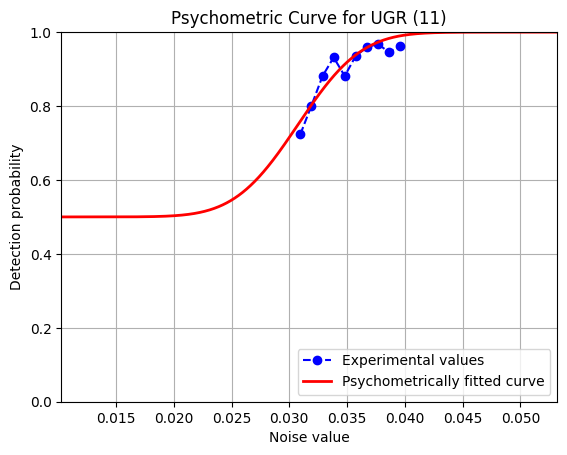

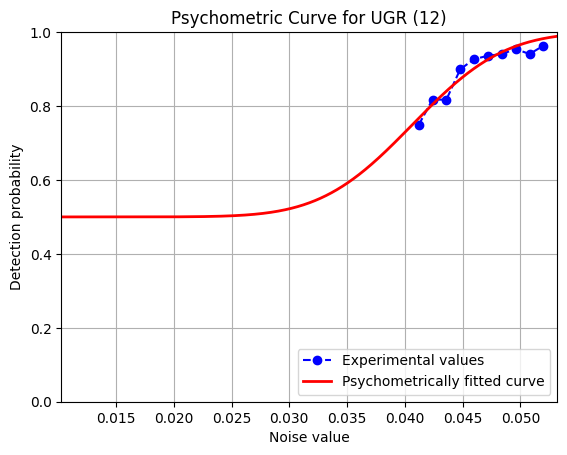

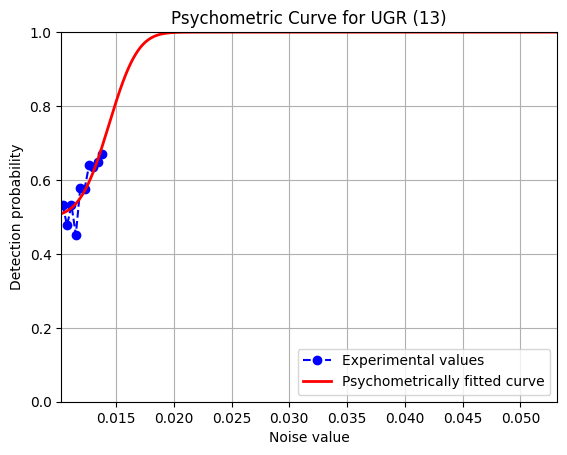

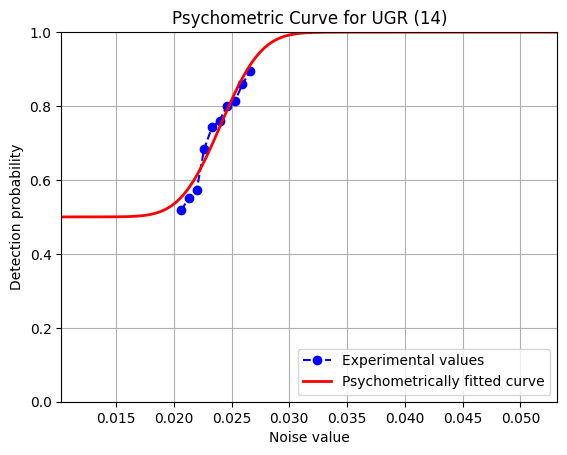

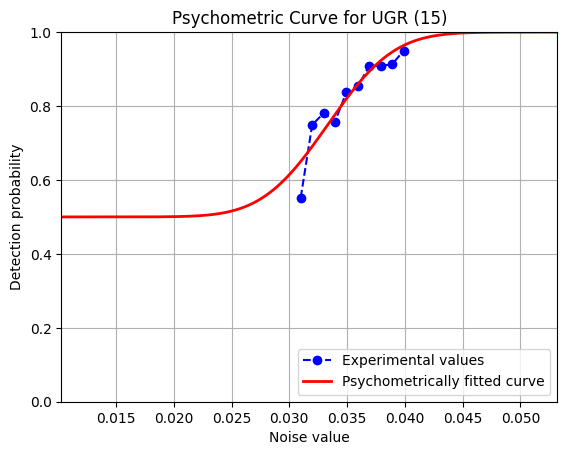

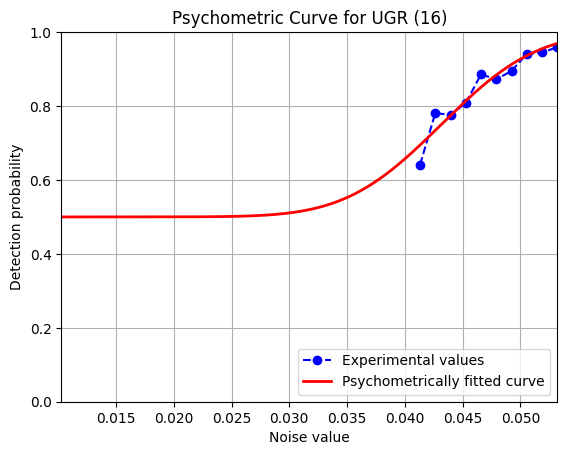

<Figure size 640x480 with 0 Axes>

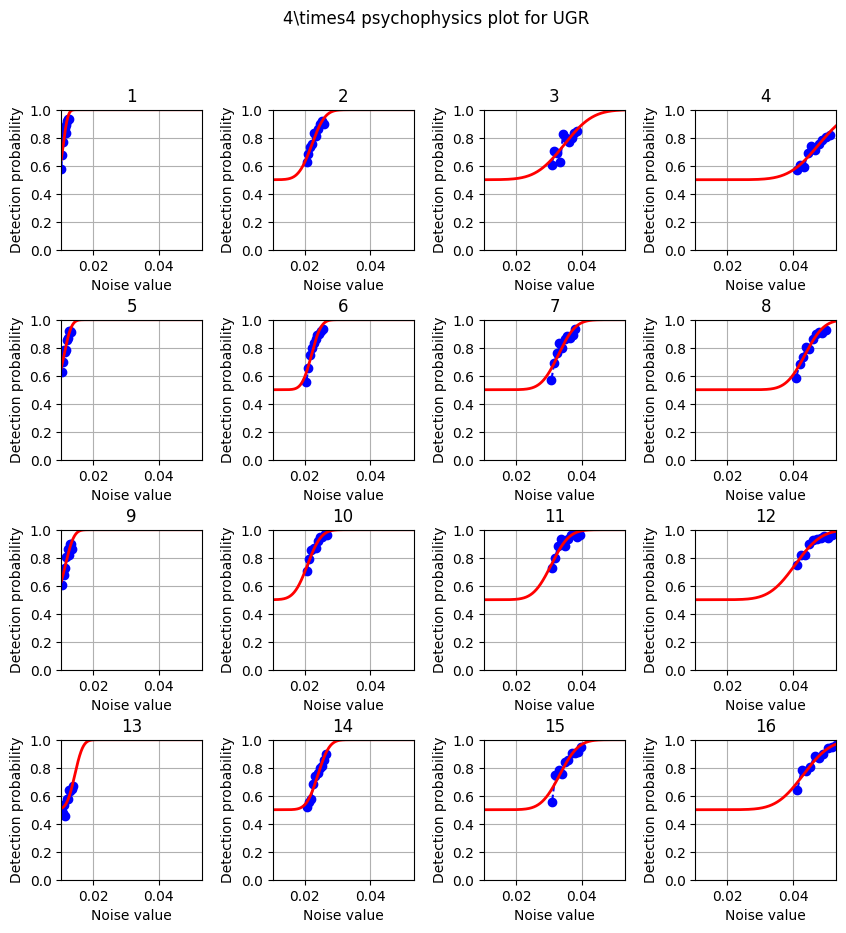

<Figure size 640x480 with 0 Axes>

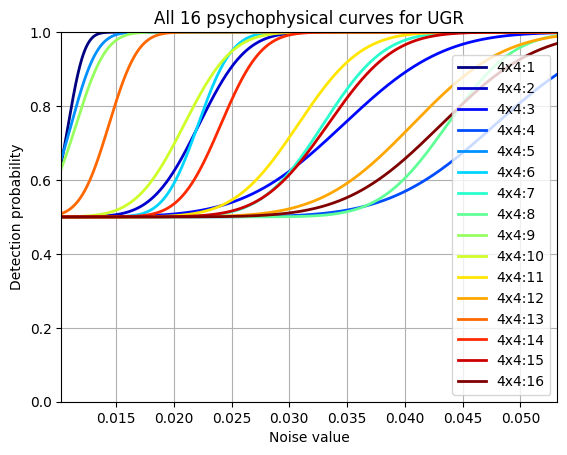

In [11]:
# UGR
mean_result_ugr = None
mean_std_ugr = []
for fichero in ficheros_ugr:
    data_file = PATH_UGR+'/'+fichero
    result = scipy.io.loadmat(data_file)
    result = np.array(result['Results'])
    if mean_result_ugr is None:
        mean_result_ugr = result
    else:
        mean_result_ugr = mean_result_ugr + result 
        # Suma de los resultados
        # Promediar la probabilidad y Promediar el tiempo
mean_result_ugr = mean_result_ugr/len(ficheros_ugr) # Media de los resultados para todos los ficheros de la UGR
    
# Individual plot
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    y = mean_result_ugr[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # parámetros para el ajuste
    params = {'x': x, 'y': y}

    # minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    # resultados en gráficos independientes
    plt.figure(i)
    plt.plot(x, y, 'o--b')
    plt.axis([min(x), max(x), 0, 1])
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    plt.plot(x_curve, y_curve, '-r', linewidth=2)
    plt.title('Psychometric Curve for UGR ('+ str(i+1)+")")
    plt.xlabel('Noise value')
    plt.ylabel('Detection probability')
    plt.legend(['Experimental values', 'Psychometrically fitted curve'], loc='lower right')
    plt.grid(True)
    plt.xlim([minX, maxX])
    plt.ylim([0, 1])

    # Guardar el gráfico y los datos en .npy
    plt.savefig(RESULTS_PATH_UGR+'/UGR-plot-' + str(i+1) + '.png')
    np.save(RESULTS_PATH_UGR+'/UGR-MeanStdDistribution-' + str(i+1) + '.npy', meanAndStdDistrib)
    mean_std_ugr.append((ruido_base, round(ParamsOpt[0], 6), round(ParamsOpt[1], 6)))

    plt.show()


# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_ugr[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x, y, 'o--b')
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_title(str(i+1))
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

figure.suptitle('4\\times4 psychophysics plot for UGR')
plt.savefig(RESULTS_PATH_UGR+'/UGR-MosaicWithEqualXAxes-' + str(i+1) + '.png')

# All 16 psychophysical curves

plt.figure() 
cc = plt.get_cmap('jet')(np.linspace(0, 1, 16))

fig, ax = plt.subplots()
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_ugr[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, linewidth=2, color=cc[i])
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

ax.set_title('All 16 psychophysical curves for UGR')

Legend = []
for i in range(16):
    Legend.append('4x4:{}'.format(i+1))

ax.legend(Legend)

plt.savefig(RESULTS_PATH_UGR+'/UGR-AllPsychomPlots-' + str(i+1) + '.png')
print()

In [12]:
data_ugr = [row for row in [mean_std_ugr[i:i+4] for i in range(0, 16, 4)]]
for row in data_ugr:
    print(row)
mean_std_ugr

[(0.01, 0.010867, 0.001107), (0.02, 0.022187, 0.003187), (0.03, 0.034682, 0.006838), (0.04, 0.047834, 0.007186)]
[(0.01, 0.011123, 0.001766), (0.02, 0.022106, 0.002299), (0.03, 0.032921, 0.004147), (0.04, 0.043683, 0.004548)]
[(0.01, 0.011551, 0.002026), (0.02, 0.020899, 0.003275), (0.03, 0.030758, 0.004312), (0.04, 0.040668, 0.006249)]
[(0.01, 0.01439, 0.00196), (0.02, 0.024073, 0.002754), (0.03, 0.03334, 0.004492), (0.04, 0.043154, 0.006503)]


[(0.01, 0.010867, 0.001107),
 (0.02, 0.022187, 0.003187),
 (0.03, 0.034682, 0.006838),
 (0.04, 0.047834, 0.007186),
 (0.01, 0.011123, 0.001766),
 (0.02, 0.022106, 0.002299),
 (0.03, 0.032921, 0.004147),
 (0.04, 0.043683, 0.004548),
 (0.01, 0.011551, 0.002026),
 (0.02, 0.020899, 0.003275),
 (0.03, 0.030758, 0.004312),
 (0.04, 0.040668, 0.006249),
 (0.01, 0.01439, 0.00196),
 (0.02, 0.024073, 0.002754),
 (0.03, 0.03334, 0.004492),
 (0.04, 0.043154, 0.006503)]

Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9994406115005116


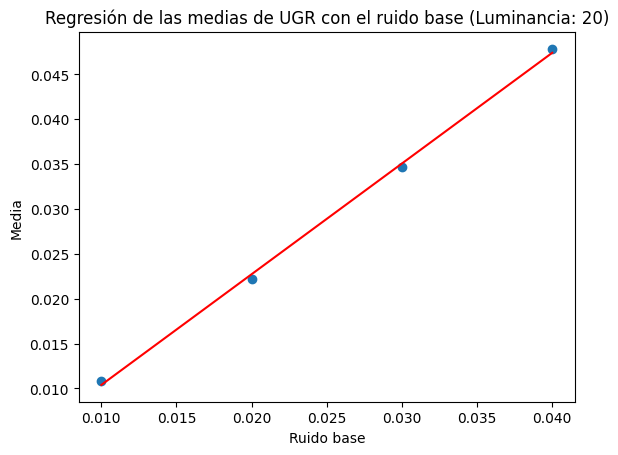

Nivel de Luminancia: 40
Coeficiente de correlación (r): 0.9999890654078368


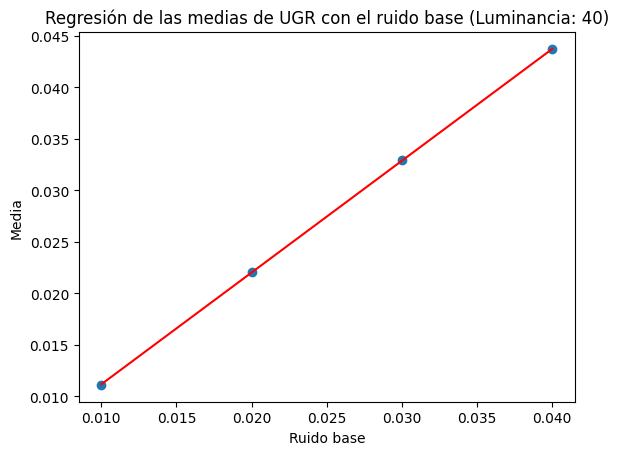

Nivel de Luminancia: 60
Coeficiente de correlación (r): 0.9999052589197416


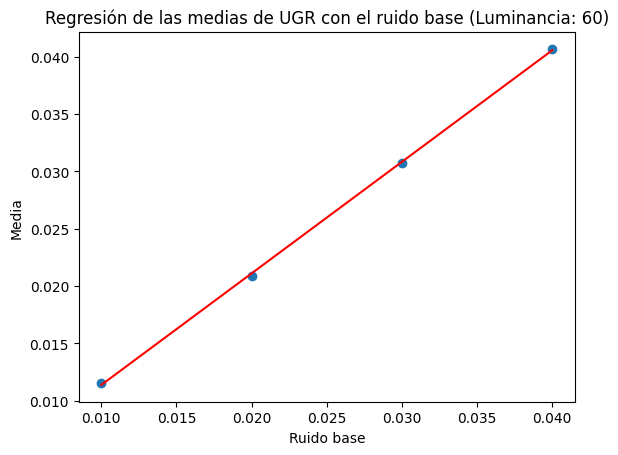

Nivel de Luminancia: 80
Coeficiente de correlación (r): 0.9999445278868593


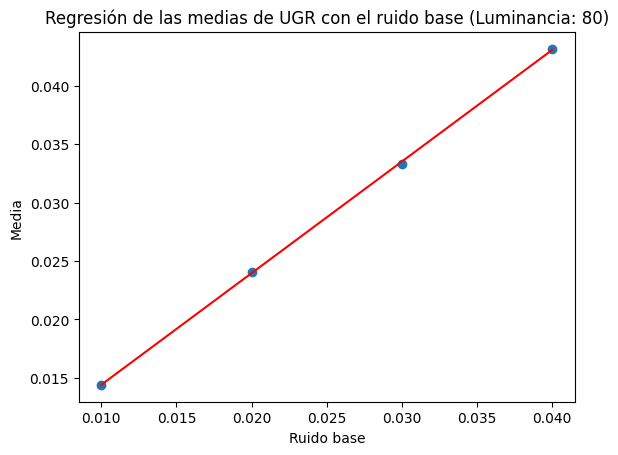

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): 0.8712792571023762


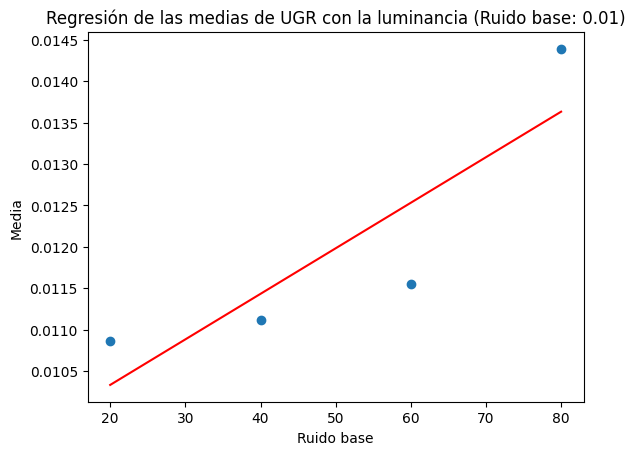

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): 0.4383284624920348


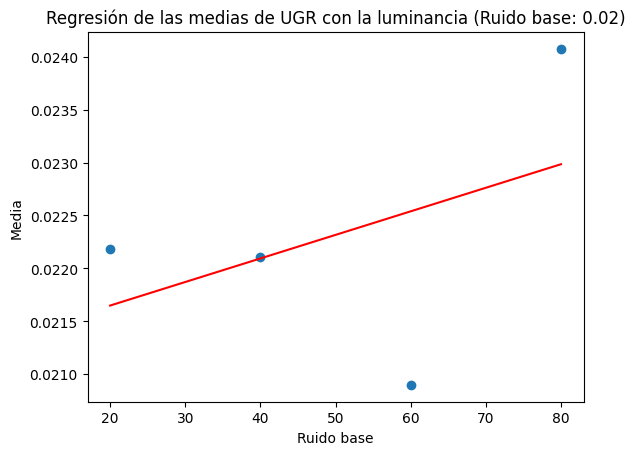

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): -0.4906598408051661


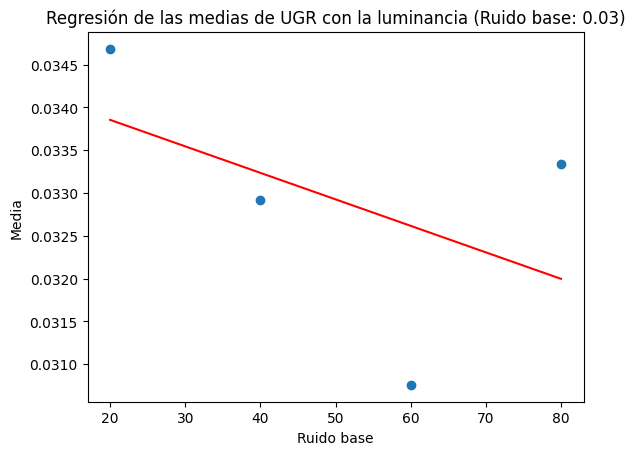

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): -0.7406995184547086


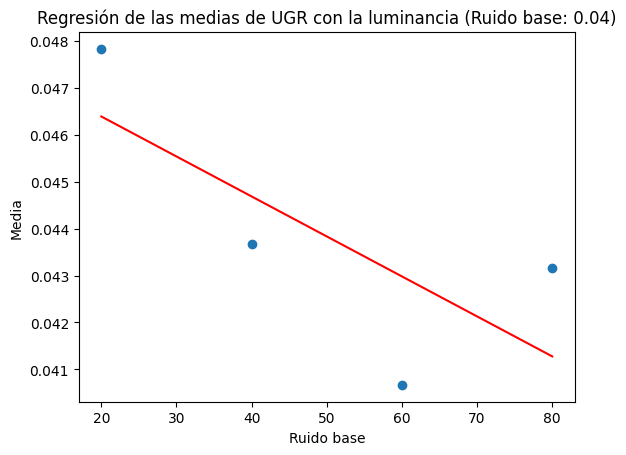

In [58]:
# Regresión de las medias y el ruido base

medias = np.array([i[1] for row in data_ugr for i in row])
ruido_base = np.array([i[0] for row in data_ugr for i in row])
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_medias = medias[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_medias)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_medias)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de las medias de UGR con el ruido base (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('Media')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_medias = medias[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_medias)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_medias)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de las medias de UGR con la luminancia (Ruido base: {})'.format(ruido))
    plt.xlabel('Ruido base')
    plt.ylabel('Media')
    plt.show()


Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9847807395049251


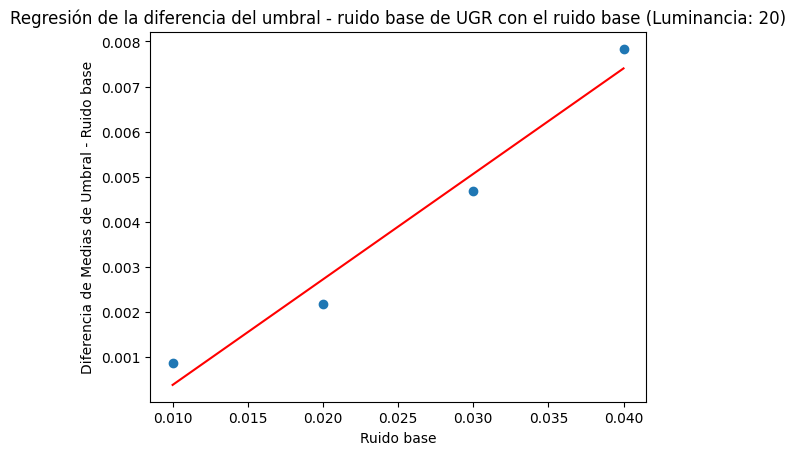

Nivel de Luminancia: 40
Coeficiente de correlación (r): 0.9982211375594069


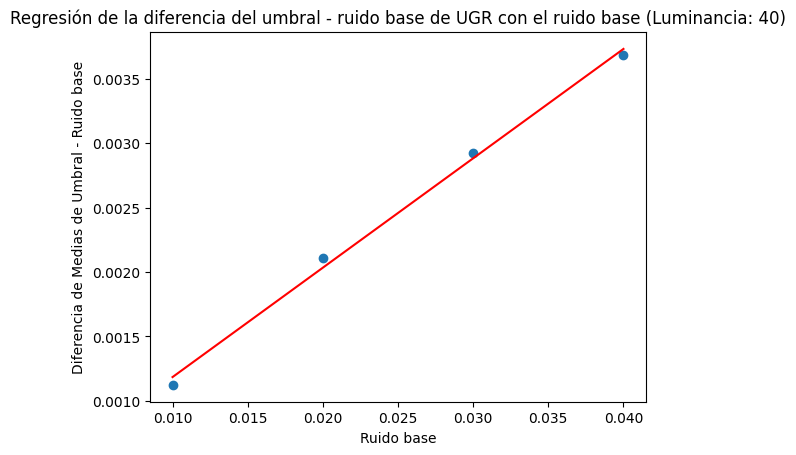

Nivel de Luminancia: 60
Coeficiente de correlación (r): -0.9016471748571949


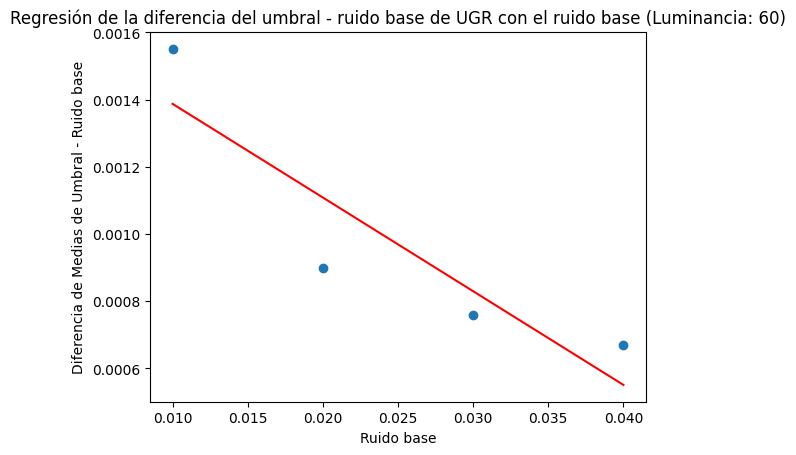

Nivel de Luminancia: 80
Coeficiente de correlación (r): -0.9752633276189709


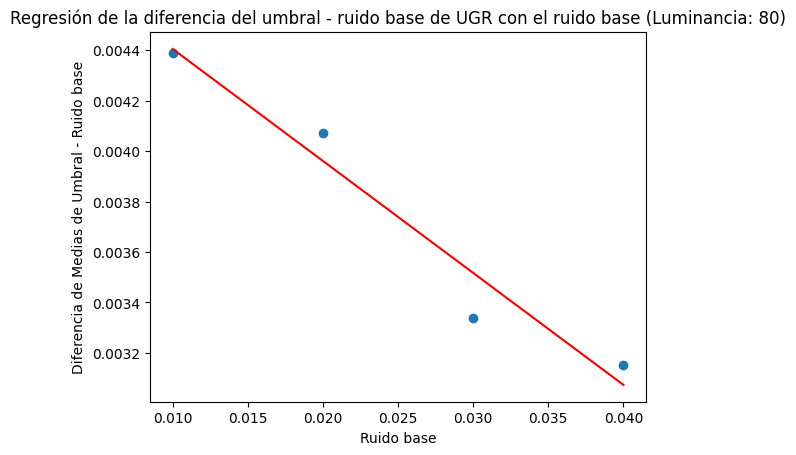

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): 0.8712792571023762


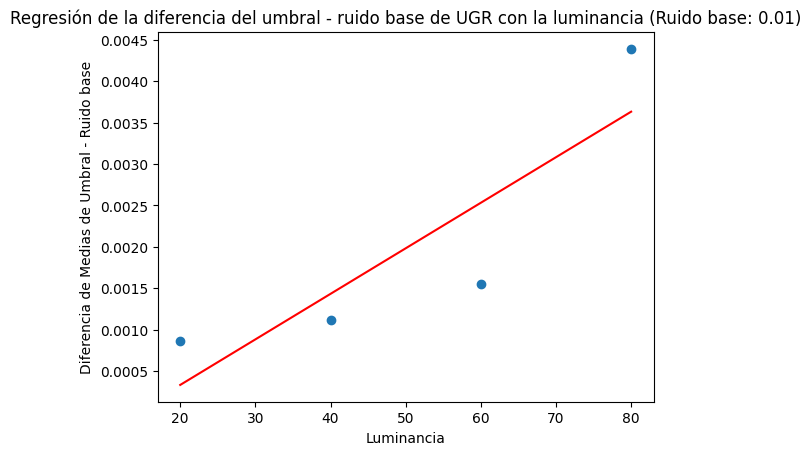

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): 0.4383284624920348


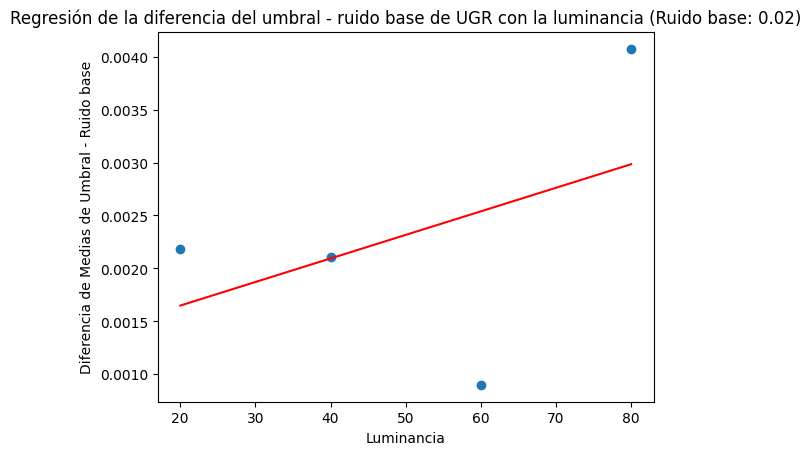

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): -0.49065984080516606


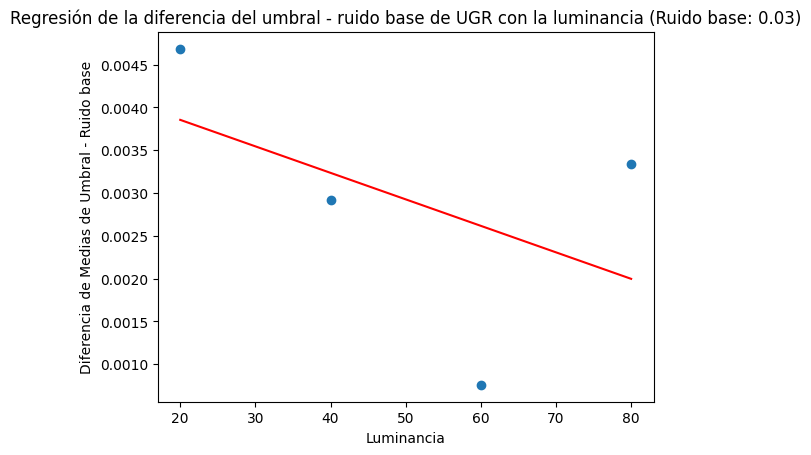

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): -0.7406995184547085


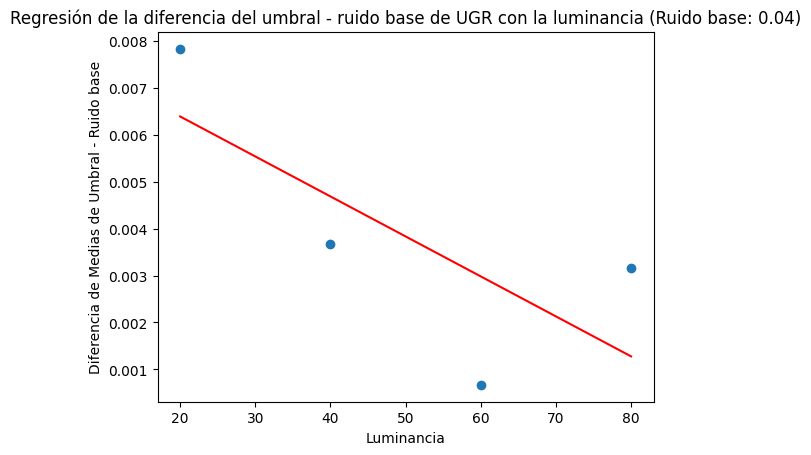

In [14]:
# Regresión de la diferencia del umbral - ruido base y el ruido base

dif_u_r = np.array([i[1]-i[0] for row in data_ugr for i in row])
ruido_base = np.array([i[0] for row in data_ugr for i in row])
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_diferencias = dif_u_r[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_diferencias)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_diferencias)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de la diferencia del umbral - ruido base de UGR con el ruido base (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('Diferencia de Medias de Umbral - Ruido base')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_diferencias = dif_u_r[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_diferencias)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_diferencias)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de la diferencia del umbral - ruido base de UGR con la luminancia (Ruido base: {})'.format(ruido))
    plt.xlabel('Luminancia')
    plt.ylabel('Diferencia de Medias de Umbral - Ruido base')
    plt.show()

[0.0867     0.10935    0.15606667 0.19585    0.1123     0.1053
 0.09736667 0.092075   0.1551     0.04495    0.02526667 0.0167
 0.439      0.20365    0.11133333 0.07885   ]
Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9914371684377624


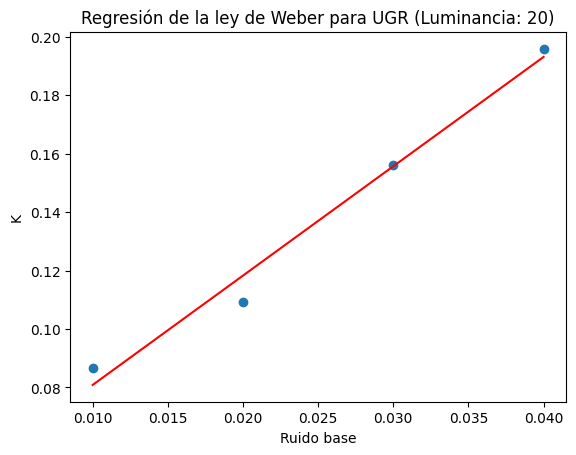

Nivel de Luminancia: 40
Coeficiente de correlación (r): -0.9971050315234917


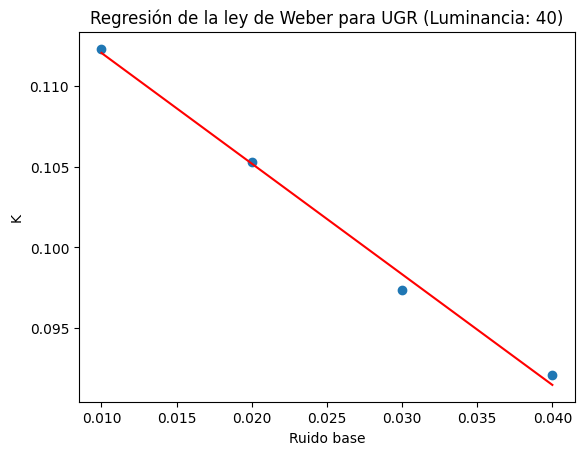

Nivel de Luminancia: 60
Coeficiente de correlación (r): -0.8750047158128096


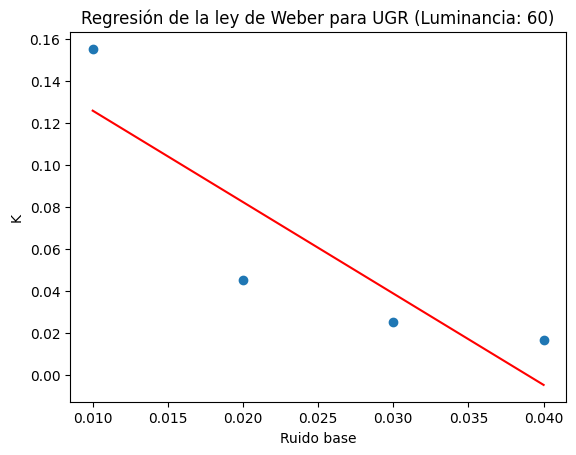

Nivel de Luminancia: 80
Coeficiente de correlación (r): -0.930627015341051


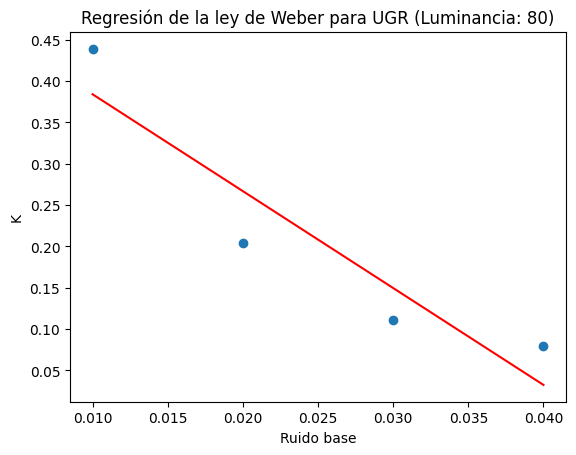

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): 0.8712792571023761


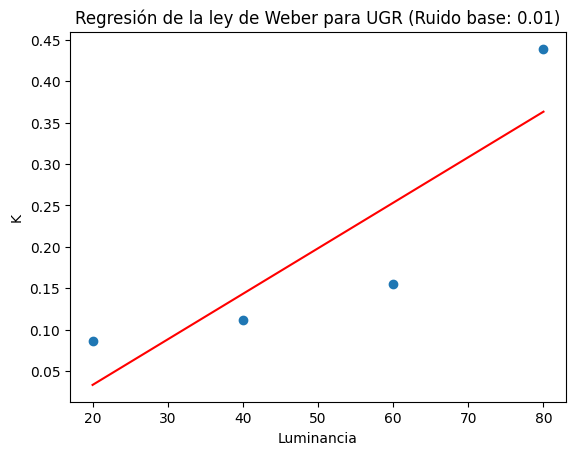

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): 0.43832846249203483


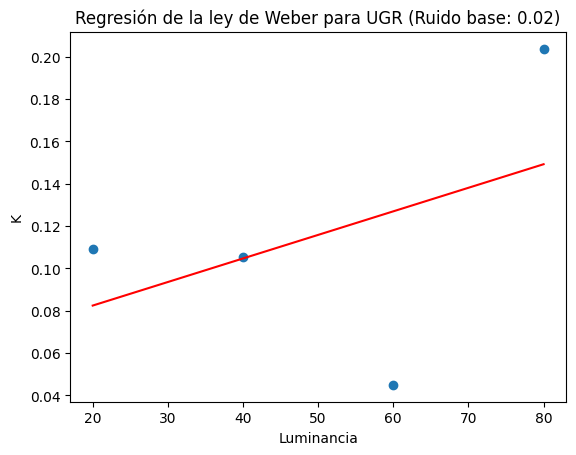

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): -0.49065984080516617


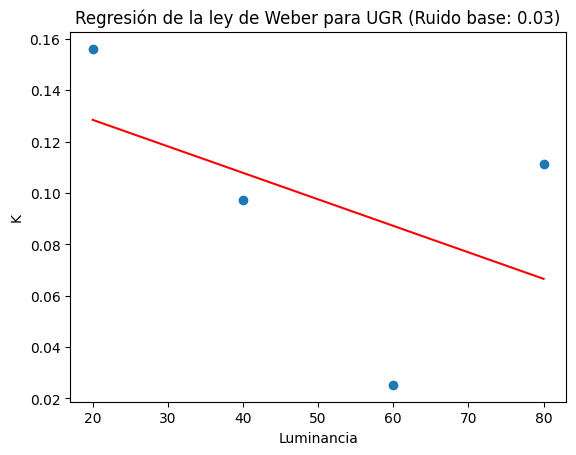

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): -0.7406995184547084


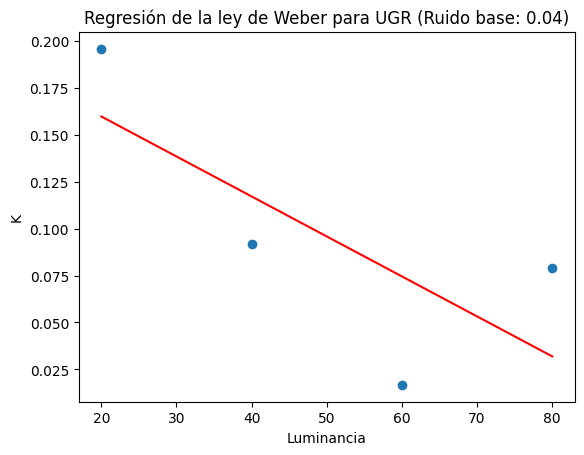

In [15]:
# Ley de Weber UGR

# La diferencia mínima perceptible entre el ruido base y el ruido umbral en cada es cociente %
# (u-r)/r = k
k = np.array([((i[1]-i[0])/i[0]) for row in data_ugr for i in row])
print(k)

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_k= k[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_k)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_k)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de la ley de Weber para UGR (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('K')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_k = k[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_k)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_k)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de la ley de Weber para UGR (Ruido base: {})'.format(ruido))
    plt.xlabel('Luminancia')
    plt.ylabel('K')
    plt.show()

Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9618524951424481


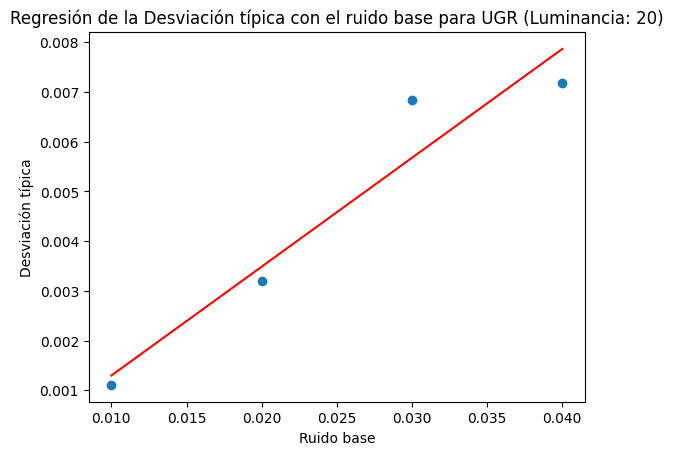

Nivel de Luminancia: 40
Coeficiente de correlación (r): 0.9648227895827755


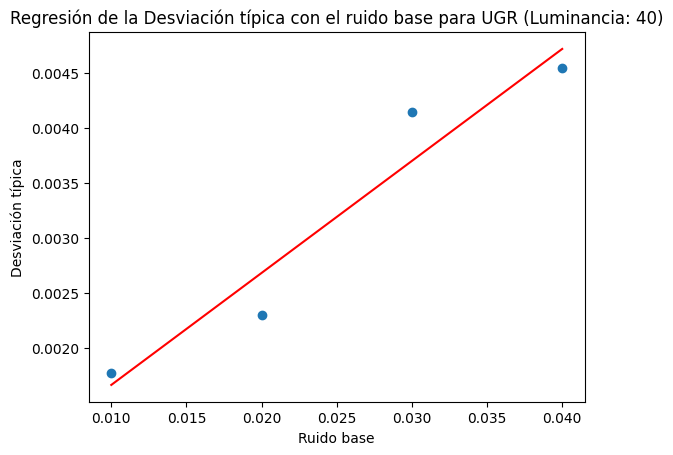

Nivel de Luminancia: 60
Coeficiente de correlación (r): 0.9905452250443894


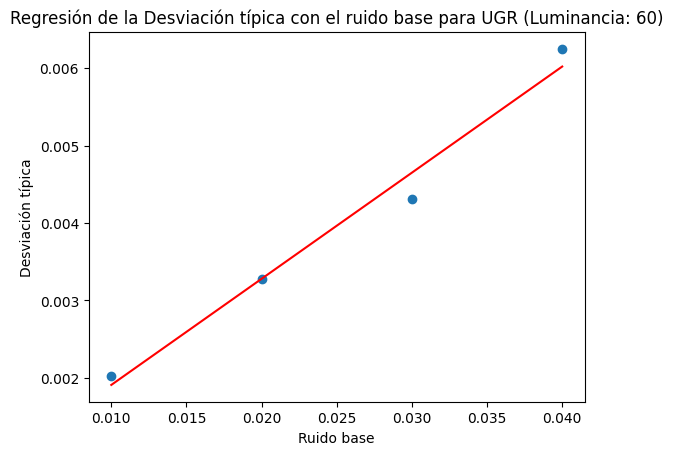

Nivel de Luminancia: 80
Coeficiente de correlación (r): 0.9837706109934279


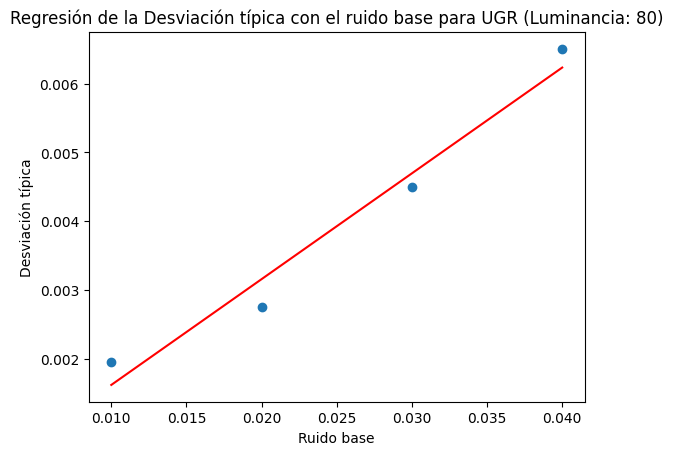

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): 0.8666581577580139


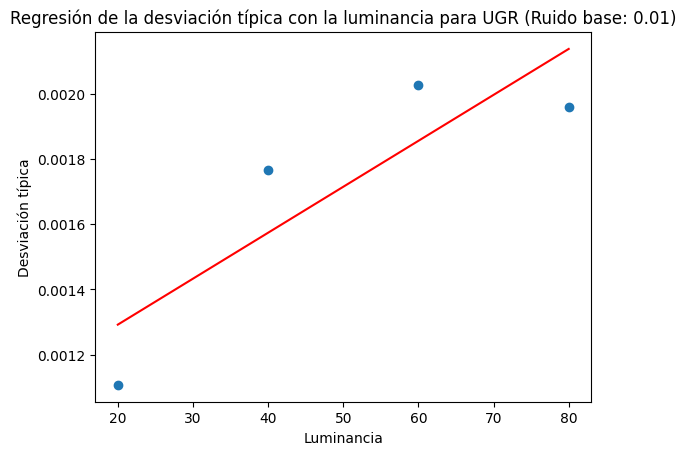

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): -0.09295552927757429


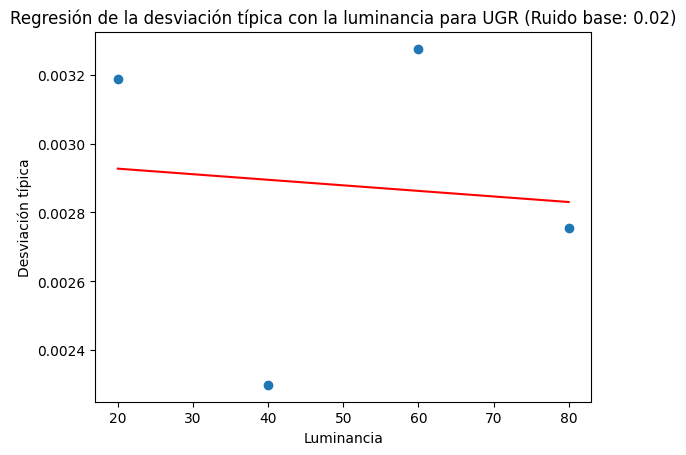

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): -0.6995710101330033


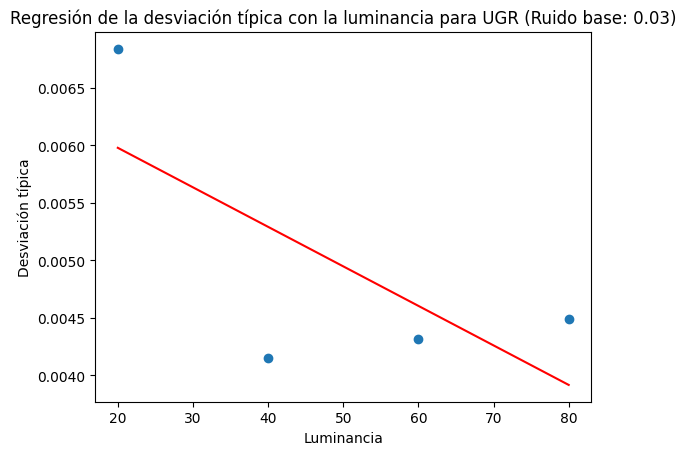

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): -0.04007227362330399


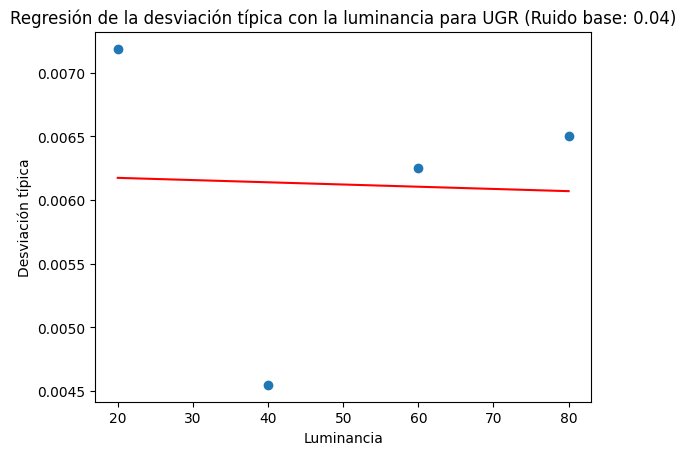

In [16]:
# Regresión de la desviación típica y el ruido base

std = np.array([i[2] for row in data_ugr for i in row])
ruido_base = np.array([i[0] for row in data_ugr for i in row])
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_std = std[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_std)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_std)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de la Desviación típica con el ruido base para UGR (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('Desviación típica')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_std = std[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_std)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_std)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de la desviación típica con la luminancia para UGR (Ruido base: {})'.format(ruido))
    plt.xlabel('Luminancia')
    plt.ylabel('Desviación típica')
    plt.show()

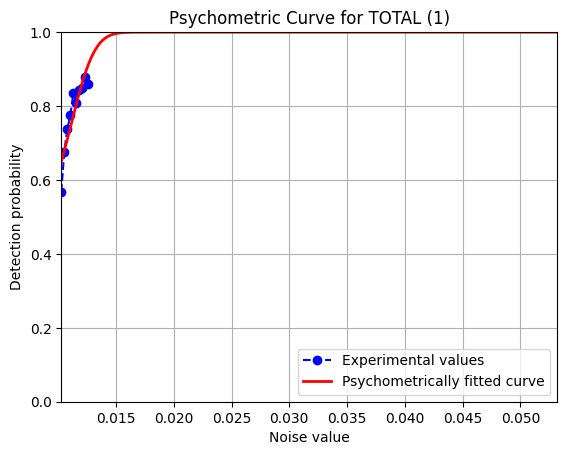

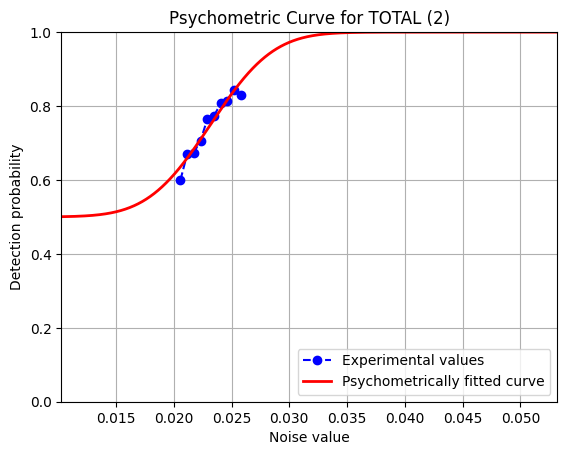

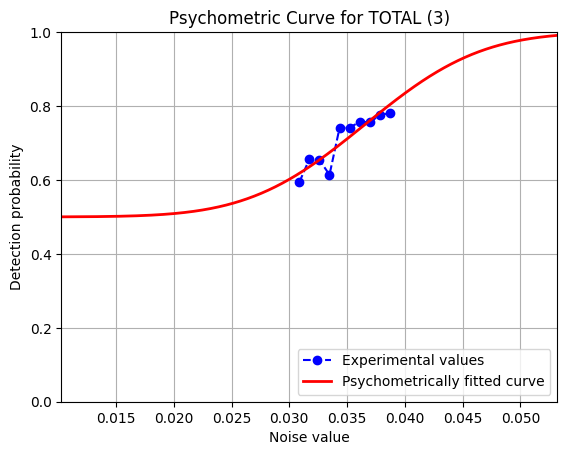

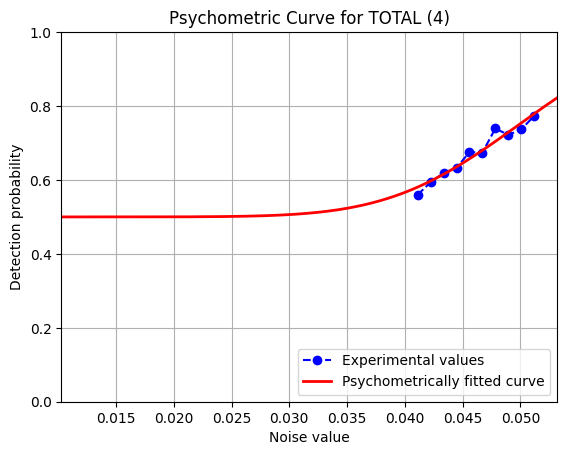

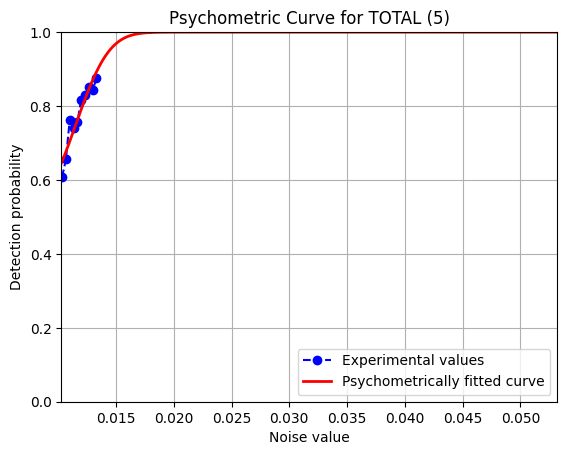

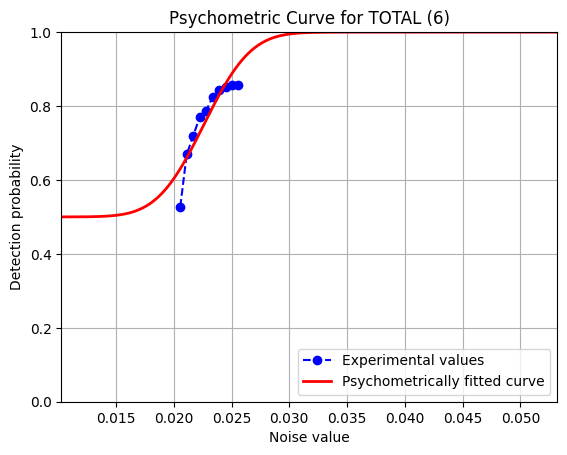

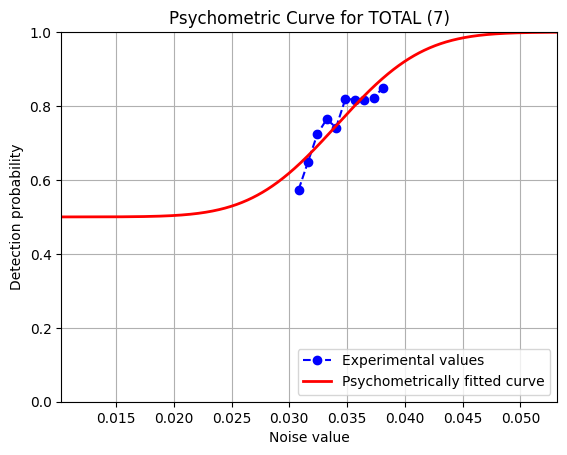

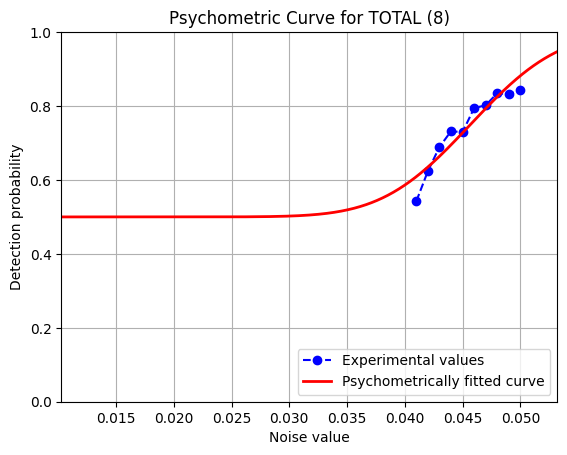

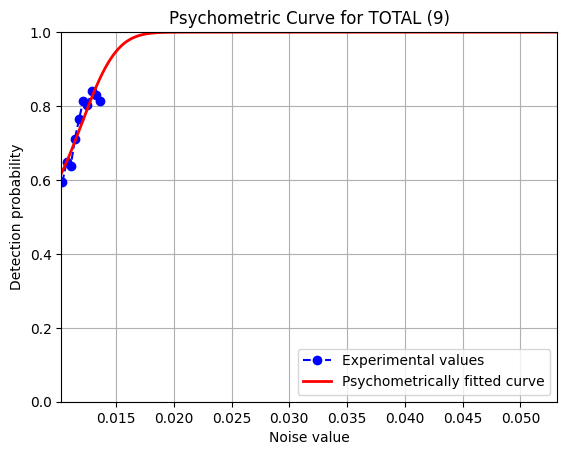

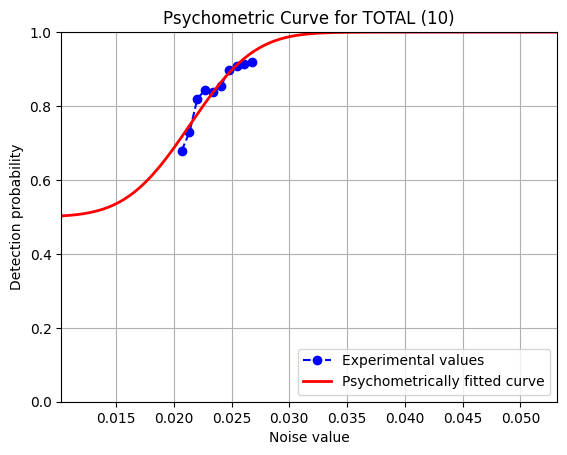

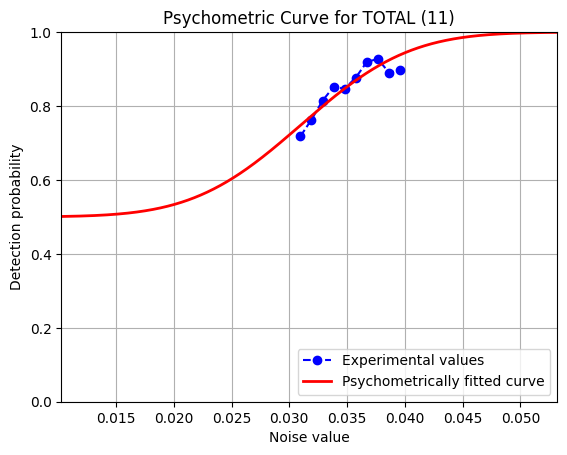

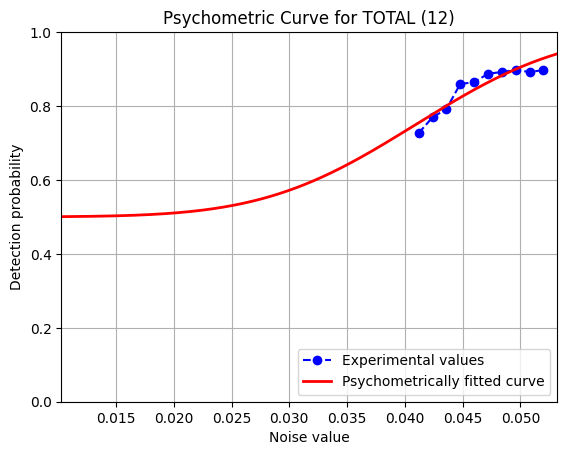

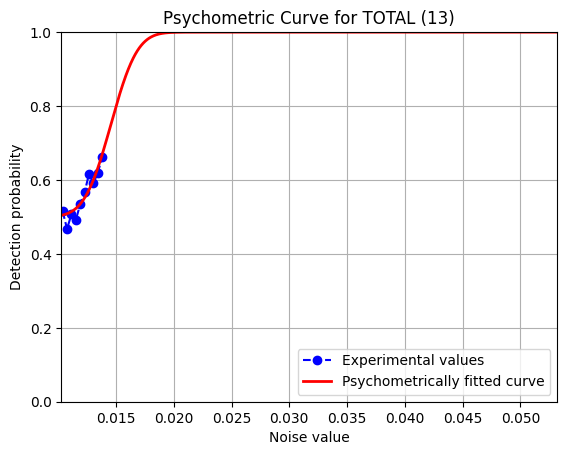

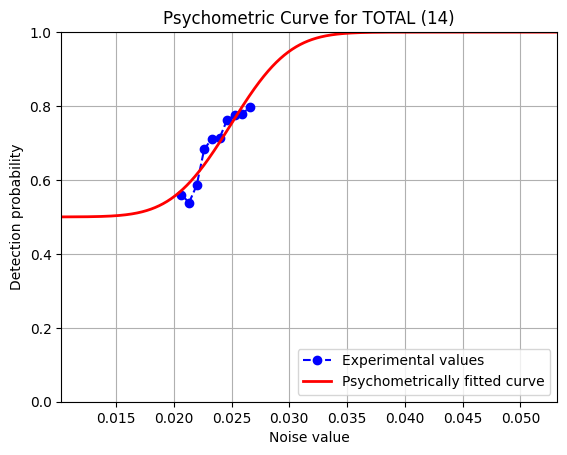

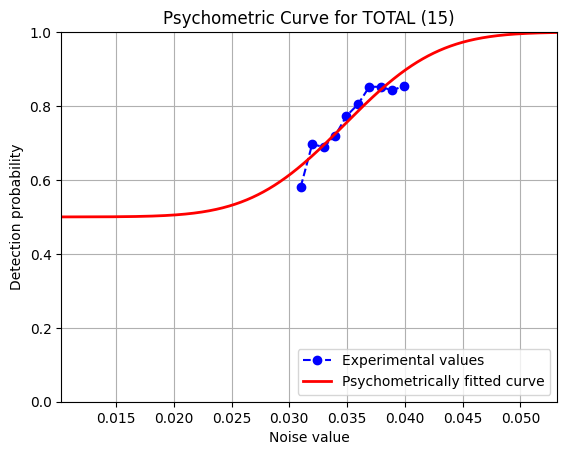

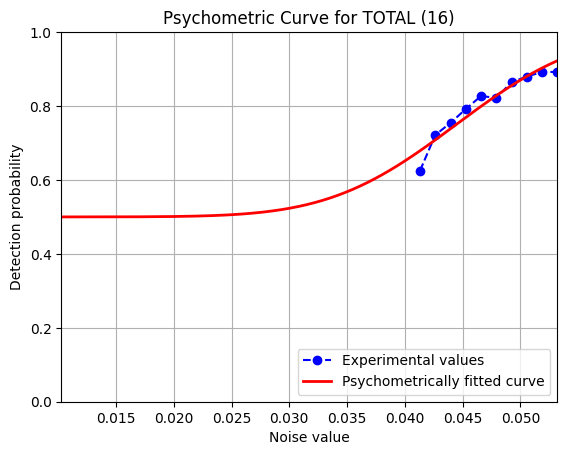

<Figure size 640x480 with 0 Axes>

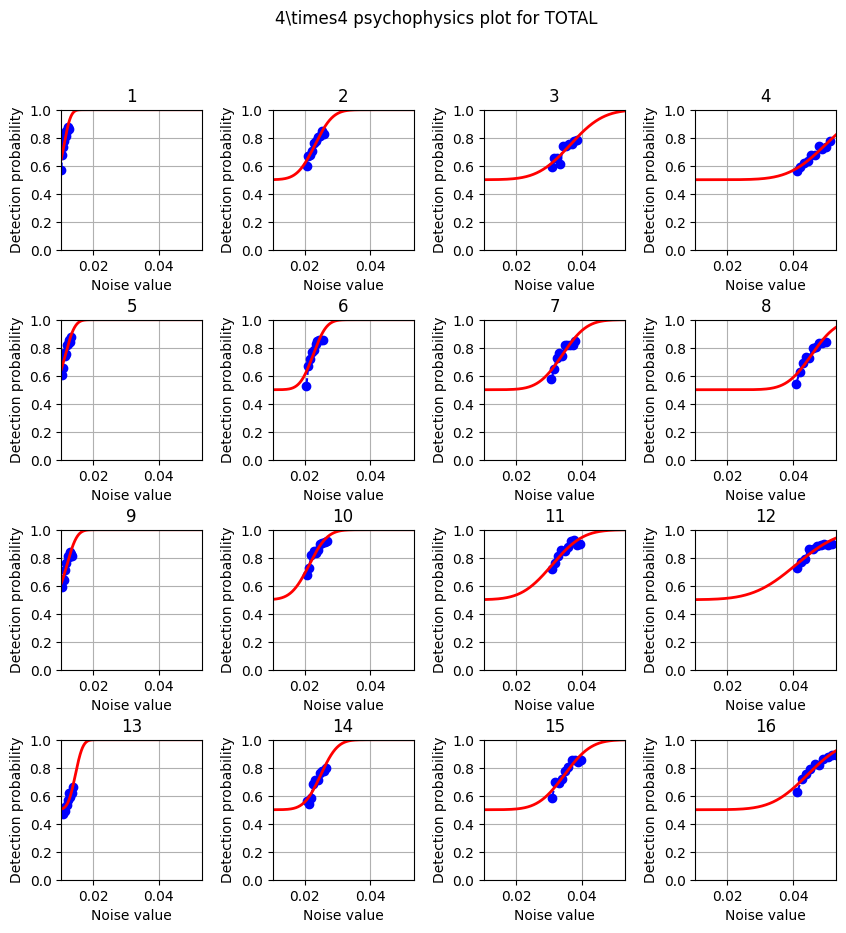

<Figure size 640x480 with 0 Axes>

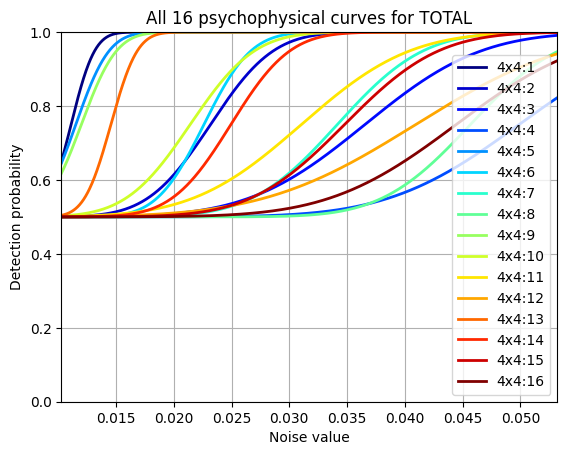

In [17]:
# TOTAL UGR + UPV
mean_result_total = None
mean_std_total = []
for fichero in ficheros_total:
    data_file = fichero
    result = scipy.io.loadmat(data_file)
    result = np.array(result['Results'])
    if mean_result_total is None:
        mean_result_total = result
    else:
        mean_result_total = mean_result_total + result 
        # Suma de los resultados
        # Promediar la probabilidad y Promediar el tiempo
mean_result_total = mean_result_total/len(ficheros_total) # Media de los resultados para todos los ficheros de la TOTAL
    
# Individual plot
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    y = mean_result_total[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # parámetros para el ajuste
    params = {'x': x, 'y': y}

    # minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    # resultados en gráficos independientes
    plt.figure(i)
    plt.plot(x, y, 'o--b')
    plt.axis([min(x), max(x), 0, 1])
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    plt.plot(x_curve, y_curve, '-r', linewidth=2)
    plt.title('Psychometric Curve for TOTAL ('+ str(i+1)+")")
    plt.xlabel('Noise value')
    plt.ylabel('Detection probability')
    plt.legend(['Experimental values', 'Psychometrically fitted curve'], loc='lower right')
    plt.grid(True)
    plt.xlim([minX, maxX])
    plt.ylim([0, 1])

    # Guardar el gráfico y los datos en .npy
    plt.savefig(RESULTS_PATH_TOTAL+'/TOTAL-plot-' + str(i+1) + '.png')
    np.save(RESULTS_PATH_TOTAL+'/TOTAL-MeanStdDistribution-' + str(i+1) + '.npy', meanAndStdDistrib)
    mean_std_total.append((ruido_base, round(ParamsOpt[0], 6), round(ParamsOpt[1], 6)))

    plt.show()


# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_total[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x, y, 'o--b')
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_title(str(i+1))
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

figure.suptitle('4\\times4 psychophysics plot for TOTAL')
plt.savefig(RESULTS_PATH_TOTAL+'/TOTAL-MosaicWithEqualXAxes-' + str(i+1) + '.png')


# All 16 psychophysical curves

plt.figure() 
cc = plt.get_cmap('jet')(np.linspace(0, 1, 16))

fig, ax = plt.subplots()
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = mean_result_total[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, linewidth=2, color=cc[i])
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

ax.set_title('All 16 psychophysical curves for TOTAL')

Legend = []
for i in range(16):
    Legend.append('4x4:{}'.format(i+1))

ax.legend(Legend)

plt.savefig(RESULTS_PATH_TOTAL+'/TOTAL-AllPsychomPlots-' + str(i+1) + '.png')

In [18]:
data_total = [row for row in [mean_std_total[i:i+4] for i in range(0, 16, 4)]]
for row in data_total:
    print(row)
data_total

[(0.01, 0.011109, 0.001602), (0.02, 0.023179, 0.004269), (0.03, 0.036551, 0.0079), (0.04, 0.049895, 0.008882)]
[(0.01, 0.011517, 0.002267), (0.02, 0.022611, 0.003197), (0.03, 0.034158, 0.00583), (0.04, 0.045681, 0.006012)]
[(0.01, 0.011995, 0.002395), (0.02, 0.021421, 0.004373), (0.03, 0.031045, 0.007363), (0.04, 0.040944, 0.010311)]
[(0.01, 0.014554, 0.001798), (0.02, 0.024944, 0.00401), (0.03, 0.034783, 0.006386), (0.04, 0.044452, 0.008614)]


[[(0.01, 0.011109, 0.001602),
  (0.02, 0.023179, 0.004269),
  (0.03, 0.036551, 0.0079),
  (0.04, 0.049895, 0.008882)],
 [(0.01, 0.011517, 0.002267),
  (0.02, 0.022611, 0.003197),
  (0.03, 0.034158, 0.00583),
  (0.04, 0.045681, 0.006012)],
 [(0.01, 0.011995, 0.002395),
  (0.02, 0.021421, 0.004373),
  (0.03, 0.031045, 0.007363),
  (0.04, 0.040944, 0.010311)],
 [(0.01, 0.014554, 0.001798),
  (0.02, 0.024944, 0.00401),
  (0.03, 0.034783, 0.006386),
  (0.04, 0.044452, 0.008614)]]

Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9997064764431643


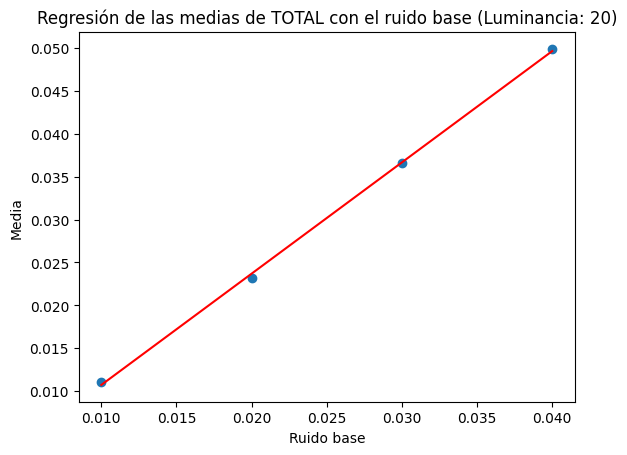

Nivel de Luminancia: 40
Coeficiente de correlación (r): 0.9999558759156838


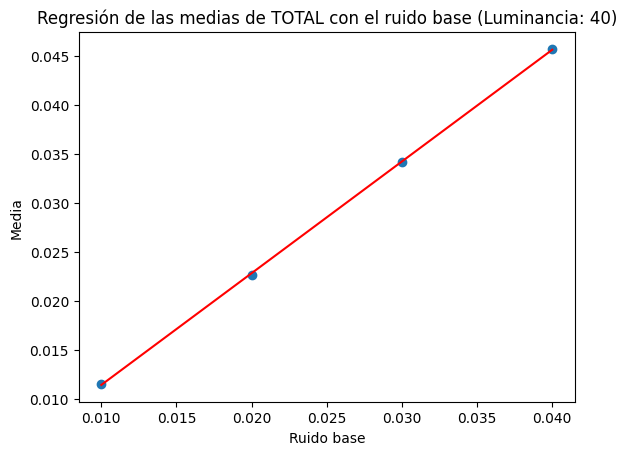

Nivel de Luminancia: 60
Coeficiente de correlación (r): 0.999939587734048


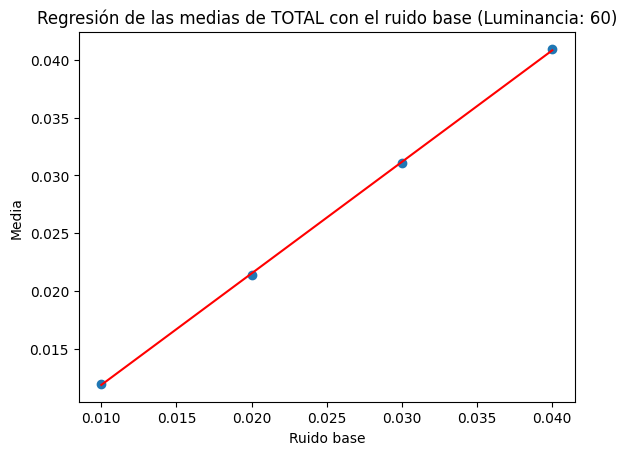

Nivel de Luminancia: 80
Coeficiente de correlación (r): 0.9998615198175614


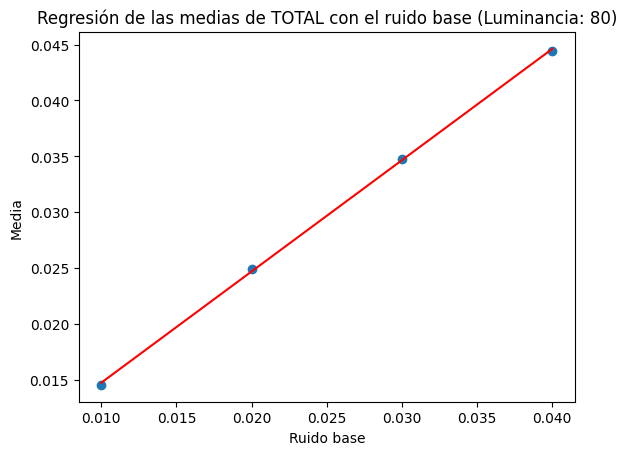

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): 0.9007734486336084


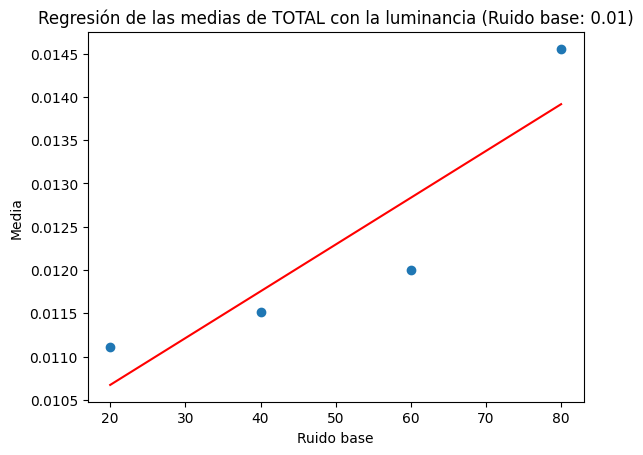

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): 0.3614325849427074


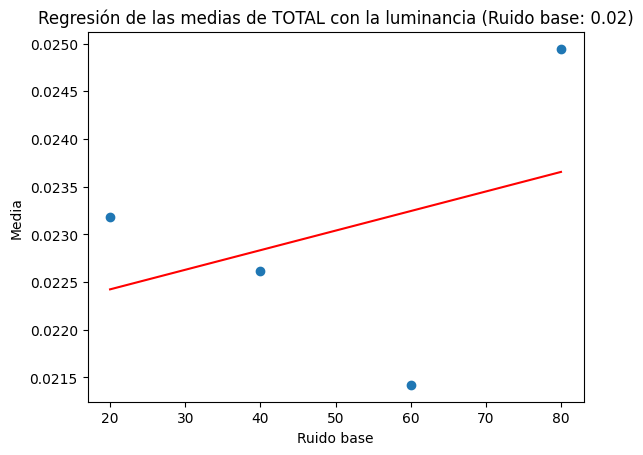

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): -0.4734095536405269


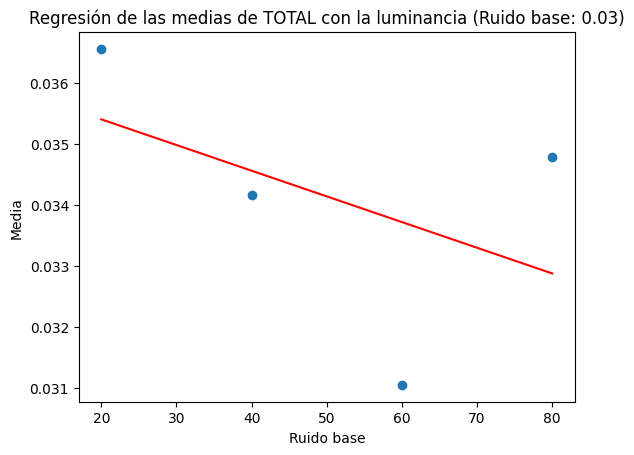

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): -0.7361952376615022


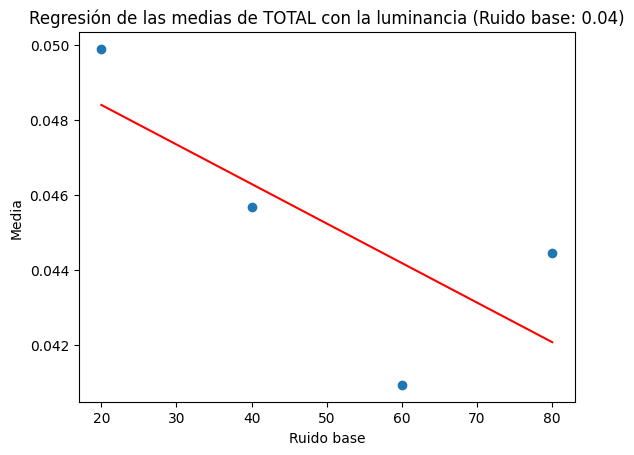

In [66]:
# Regresión de las medias y el ruido base

medias = np.array([i[1] for row in data_total for i in row])
ruido_base = np.array([i[0] for row in data_total for i in row])
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_medias = medias[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_medias)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_medias)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de las medias de TOTAL con el ruido base (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('Media')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_medias = medias[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_medias)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_medias)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de las medias de TOTAL con la luminancia (Ruido base: {})'.format(ruido))
    plt.xlabel('Ruido base')
    plt.ylabel('Media')
    plt.show()


Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9944550037982858
-0.002249
0.2973


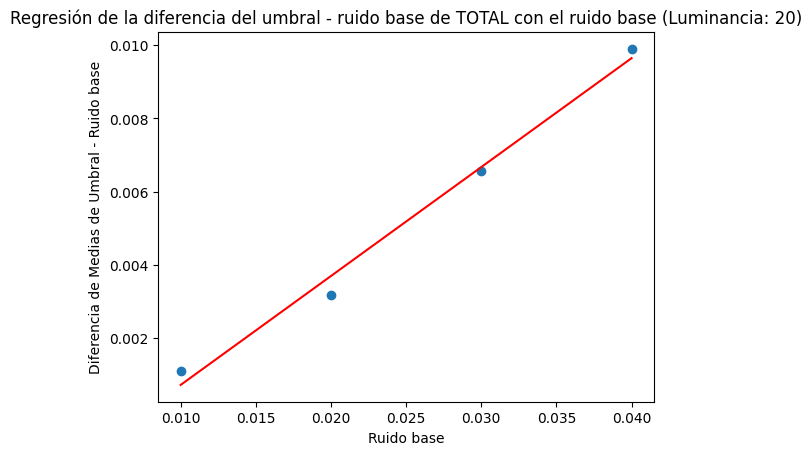

Nivel de Luminancia: 40
Coeficiente de correlación (r): 0.9971010069236206
-1.800000000000022e-05
0.14039


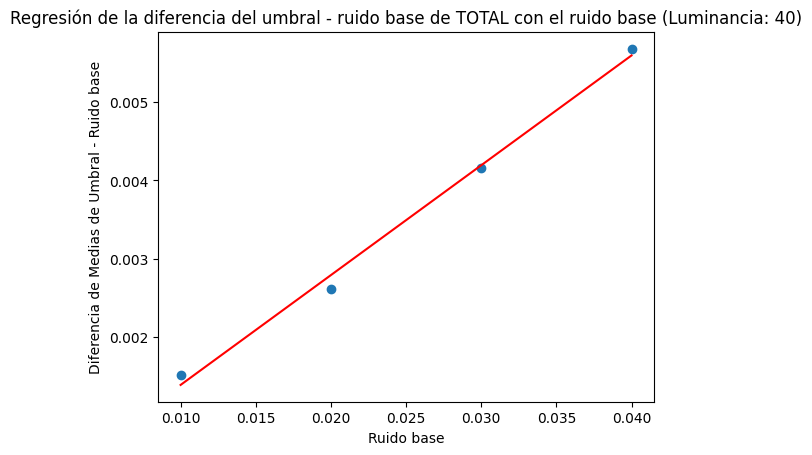

Nivel de Luminancia: 60
Coeficiente de correlación (r): -0.9576947780281514
0.0022334999999999994
-0.035289999999999974


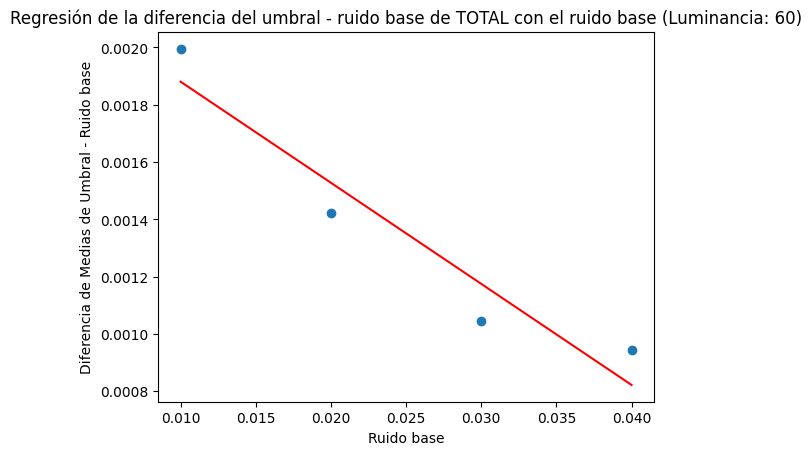

Nivel de Luminancia: 80
Coeficiente de correlación (r): -0.2713257421021808
0.0048000000000000004
-0.004670000000000022


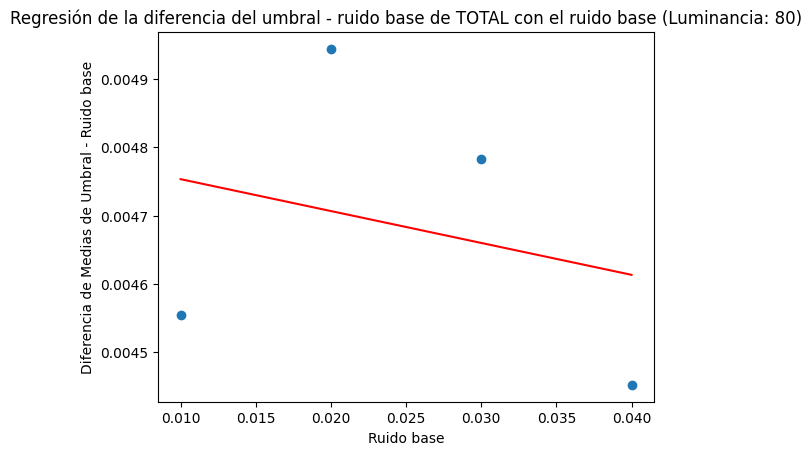

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): 0.9007734486336084


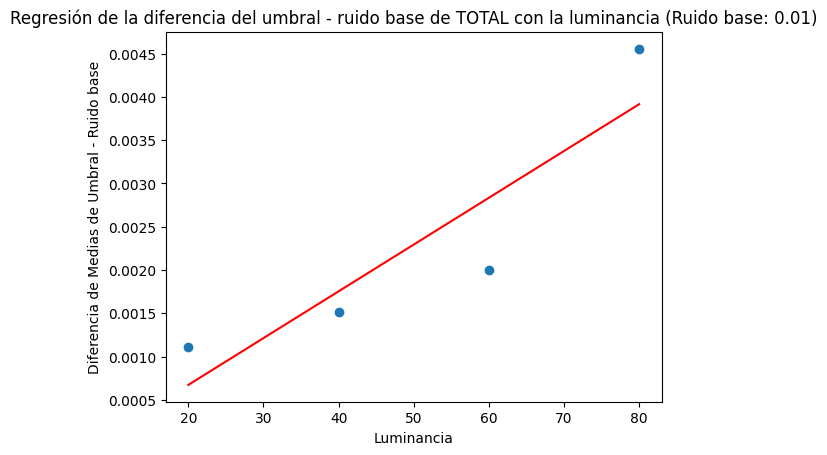

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): 0.3614325849427074


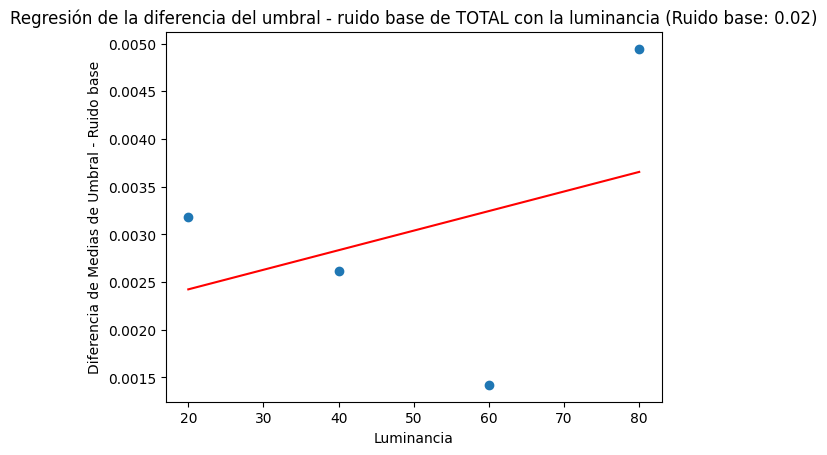

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): -0.4734095536405269


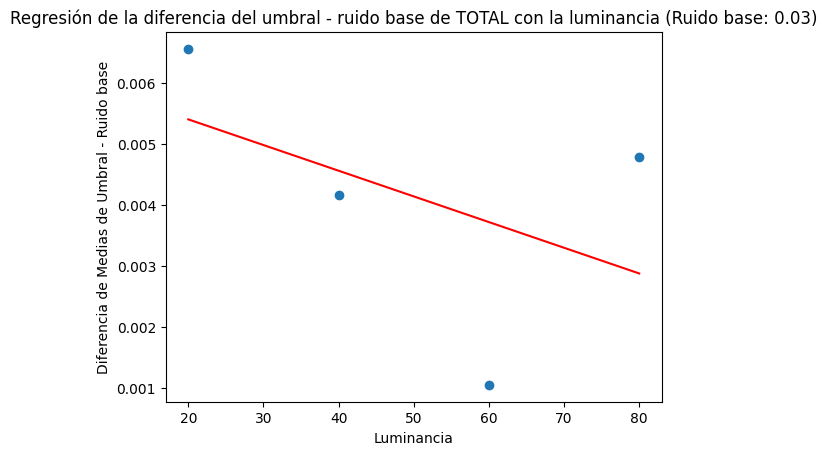

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): -0.7361952376615022


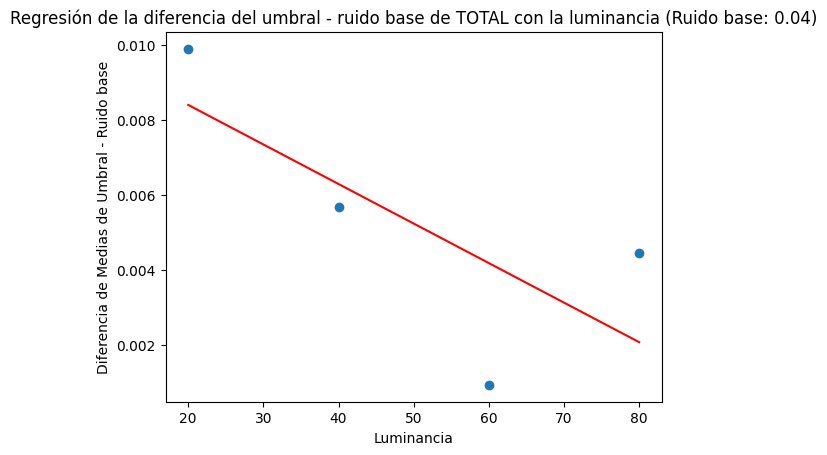

Text(0, 0.5, 'Diferencia de Medias de Umbral - Ruido base')

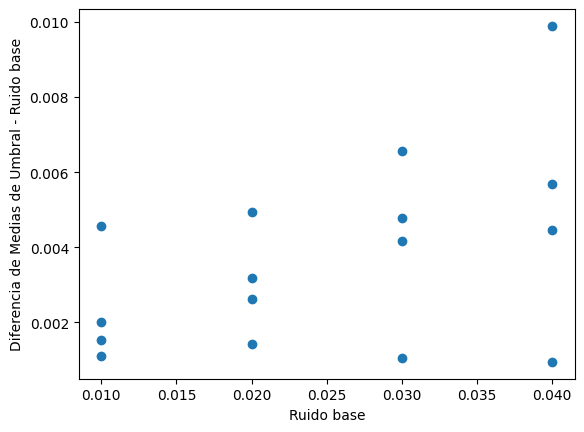

In [65]:
# Regresión de la diferencia del umbral - ruido base y el ruido base

dif_u_r = np.array([i[1]-i[0] for row in data_total for i in row])
ruido_base = np.array([i[0] for row in data_total for i in row])
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_diferencias = dif_u_r[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_diferencias)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    print(intercept)
    print(slope)
    plt.scatter(luminancia_ruido_base, luminancia_diferencias)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de la diferencia del umbral - ruido base de TOTAL con el ruido base (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('Diferencia de Medias de Umbral - Ruido base')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_diferencias = dif_u_r[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_diferencias)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_diferencias)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de la diferencia del umbral - ruido base de TOTAL con la luminancia (Ruido base: {})'.format(ruido))
    plt.xlabel('Luminancia')
    plt.ylabel('Diferencia de Medias de Umbral - Ruido base')
    plt.show()
    
plt.scatter(ruido_base, dif_u_r)
plt.xlabel('Ruido base')
plt.ylabel('Diferencia de Medias de Umbral - Ruido base')


[0.1109     0.15895    0.21836667 0.247375   0.1517     0.13055
 0.1386     0.142025   0.1995     0.07105    0.03483333 0.0236
 0.4554     0.2472     0.15943333 0.1113    ]
Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9920035148302487


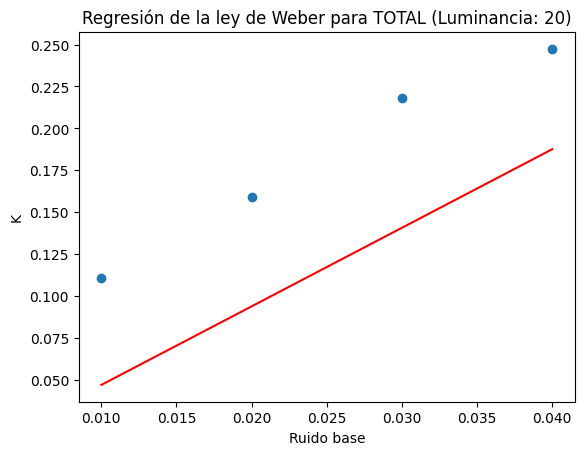

Nivel de Luminancia: 40
Coeficiente de correlación (r): -0.3091340477893752


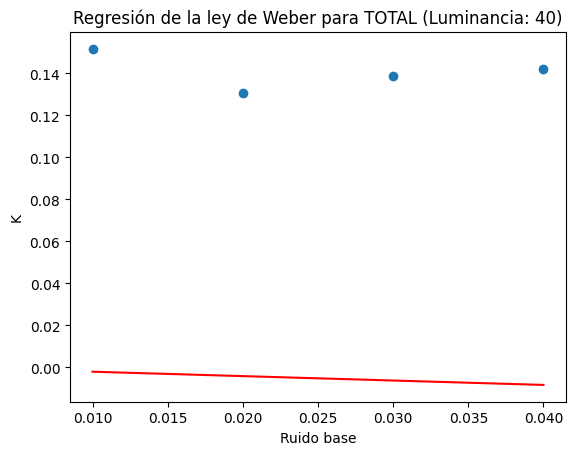

Nivel de Luminancia: 60
Coeficiente de correlación (r): -0.9015764771368048


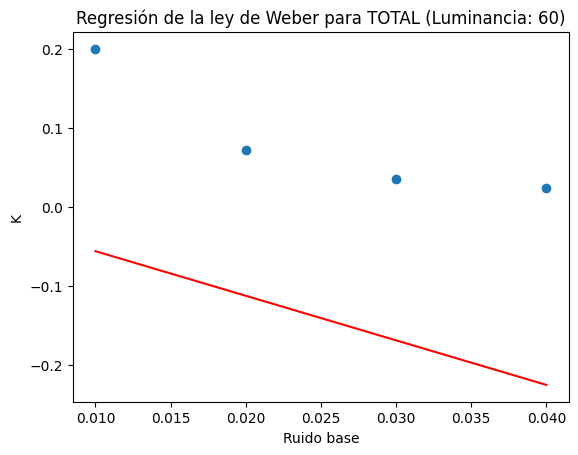

Nivel de Luminancia: 80
Coeficiente de correlación (r): -0.9503068991653035


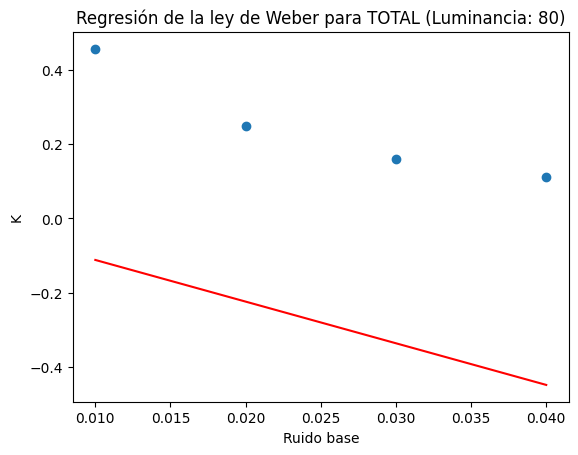

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): 0.9007734486336084


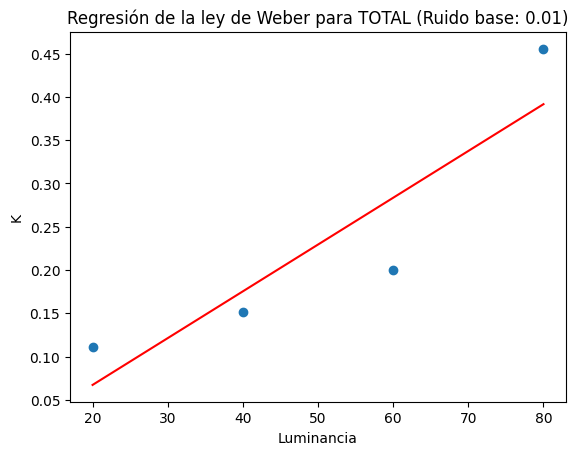

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): 0.36143258494270736


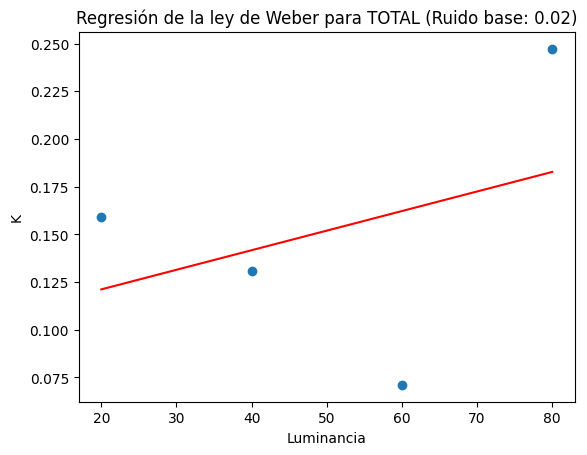

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): -0.4734095536405269


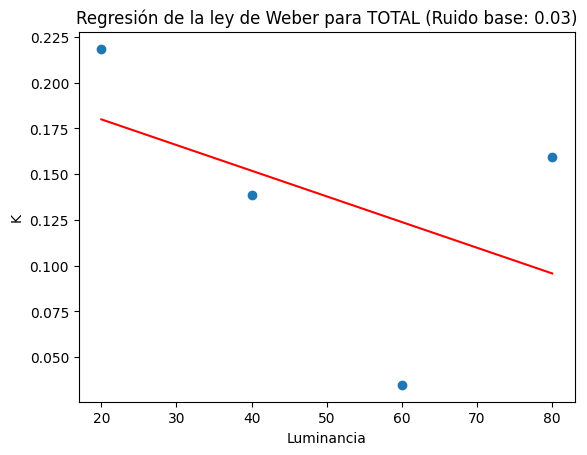

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): -0.7361952376615022


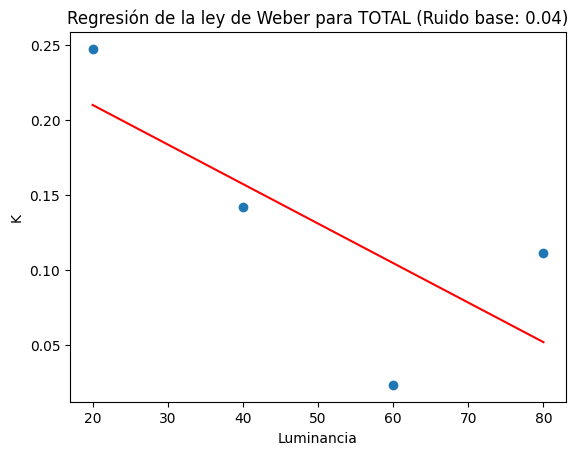

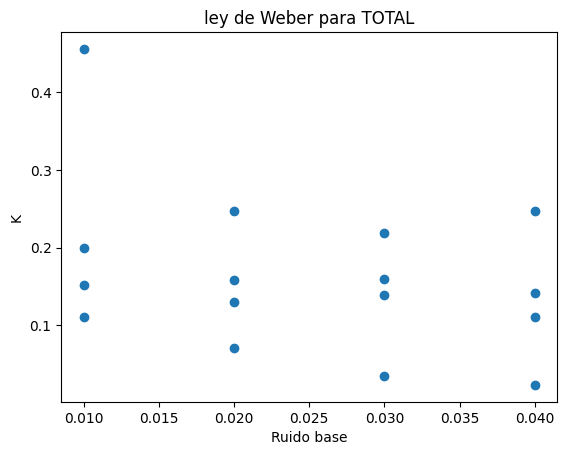

In [64]:
# Ley de Weber

# La diferencia mínima perceptible entre el ruido base y el ruido umbral en cada es cociente %
# (u-r)/r = k
k = np.array([((i[1]-i[0])/i[0]) for row in data_total for i in row])
print(k)

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_k= k[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_k)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_k)
    plt.plot(luminancia_ruido_base, slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de la ley de Weber para TOTAL (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('K')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_k = k[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_k)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_k)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de la ley de Weber para TOTAL (Ruido base: {})'.format(ruido))
    plt.xlabel('Luminancia')
    plt.ylabel('K')
    plt.show()

k = np.array([((i[1]-i[0])/i[0]) for row in data_total for i in row])
    
plt.scatter(ruido_base, k)
plt.title('ley de Weber para TOTAL'.format(ruido))
plt.xlabel('Ruido base')
plt.ylabel('K')
plt.show()    

Nivel de Luminancia: 20
Coeficiente de correlación (r): 0.9796380974386835


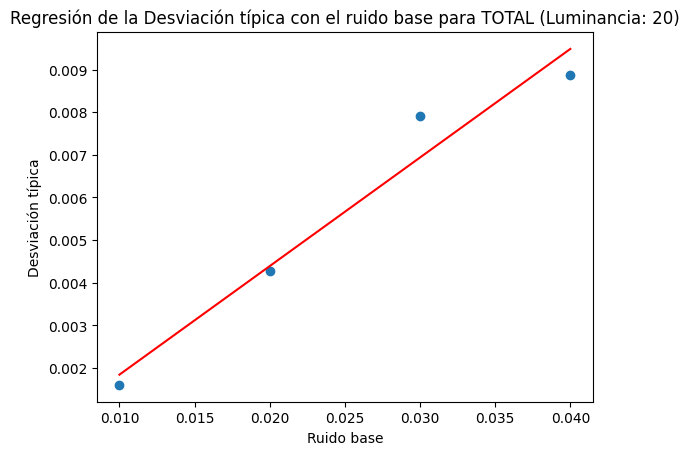

Nivel de Luminancia: 40
Coeficiente de correlación (r): 0.9516176417346816


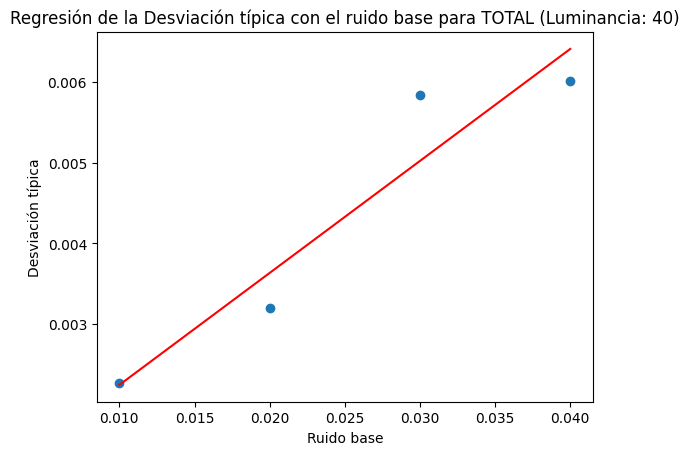

Nivel de Luminancia: 60
Coeficiente de correlación (r): 0.9959574699898294


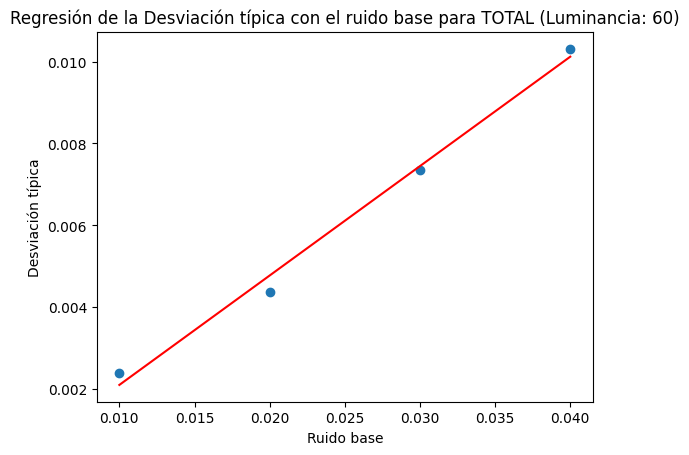

Nivel de Luminancia: 80
Coeficiente de correlación (r): 0.9999053528721947


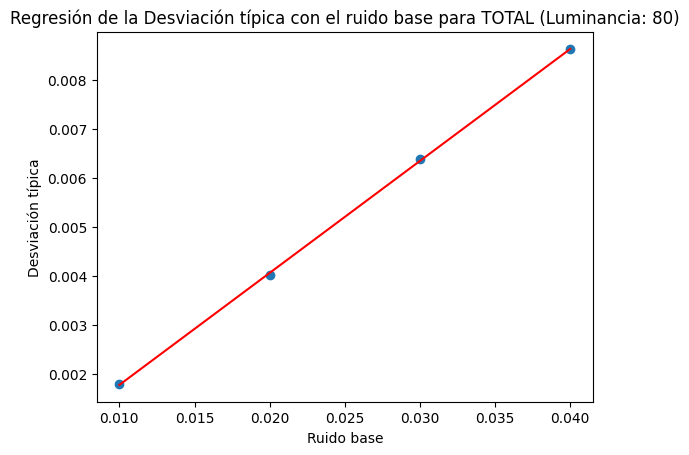

Nivel de Ruido base: 0.01
Coeficiente de correlación (r): 0.24542404747084934


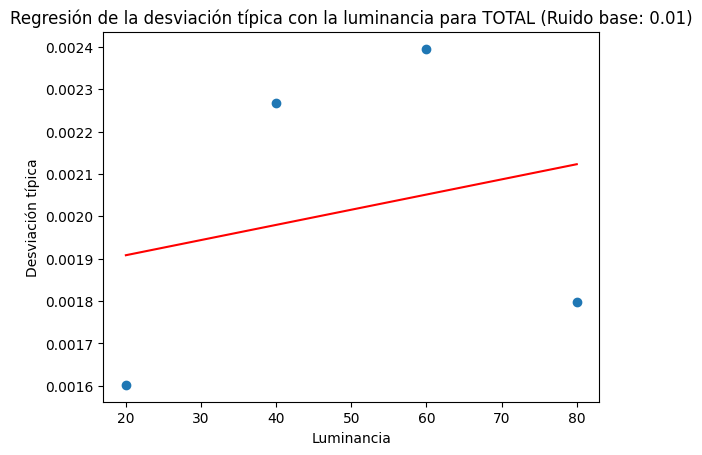

Nivel de Ruido base: 0.02
Coeficiente de correlación (r): 0.0967319628755393


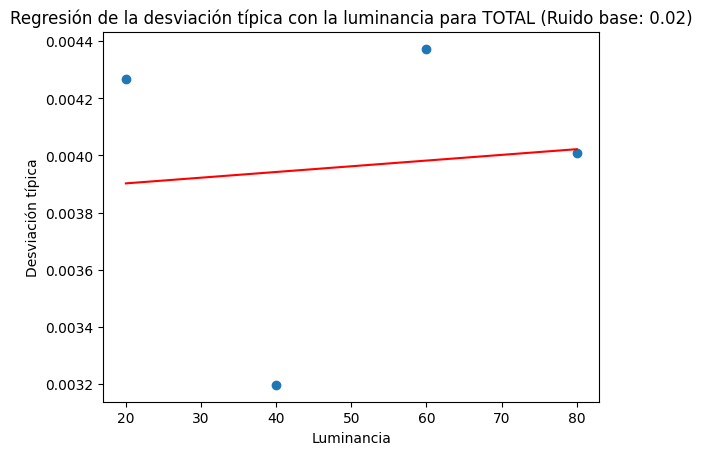

Nivel de Ruido base: 0.03
Coeficiente de correlación (r): -0.4156930152788944


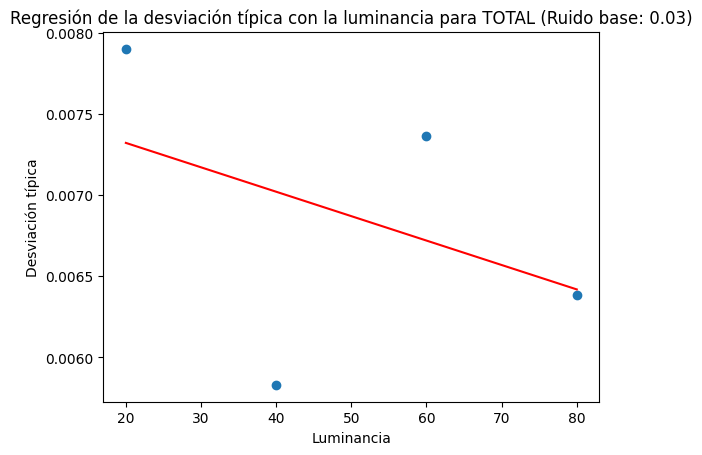

Nivel de Ruido base: 0.04
Coeficiente de correlación (r): 0.2519597806920304


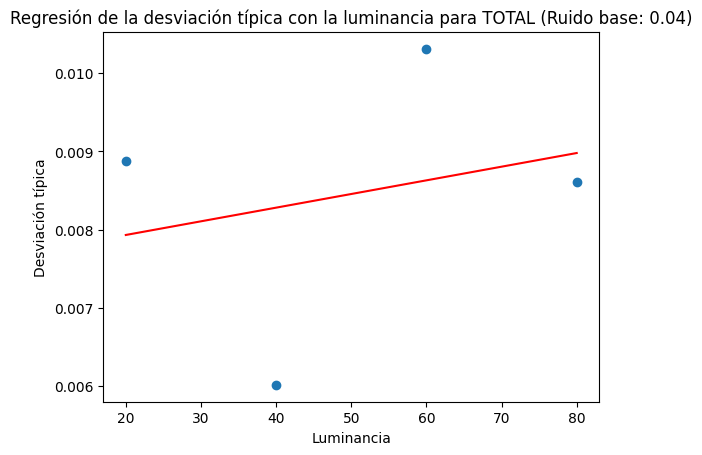

In [22]:
# Regresión de la desviación típica y el ruido base

std = np.array([i[2] for row in data_total for i in row])
ruido_base = np.array([i[0] for row in data_total for i in row])
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])

# Realizar regresión por cada nivel de luminancia
unique_luminancias = np.unique(luminancias)
unique_ruido_base = np.unique(ruido_base)
for luminancia in unique_luminancias:
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_std = std[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_std)
    print("Nivel de Luminancia:", luminancia)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(luminancia_ruido_base, luminancia_std)
    plt.plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, 'r')
    plt.title('Regresión de la Desviación típica con el ruido base para TOTAL (Luminancia: {})'.format(luminancia))
    plt.xlabel('Ruido base')
    plt.ylabel('Desviación típica')
    plt.show()

# Realizar regresión por cada nivel de ruido base
for ruido in unique_ruido_base:
    # Filtrar datos correspondientes al ruido base actual
    ruido_base_indices = np.where(ruido_base == ruido)
    ruido_base_luminancias = luminancias[ruido_base_indices]
    ruido_base_std = std[ruido_base_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(ruido_base_luminancias, ruido_base_std)
    print("Nivel de Ruido base:", ruido)
    print("Coeficiente de correlación (r):", r_value)

    # Graficar los resultados
    plt.scatter(ruido_base_luminancias, ruido_base_std)
    plt.plot(ruido_base_luminancias, intercept + slope * ruido_base_luminancias, 'r')
    plt.title('Regresión de la desviación típica con la luminancia para TOTAL (Ruido base: {})'.format(ruido))
    plt.xlabel('Luminancia')
    plt.ylabel('Desviación típica')
    plt.show()

In [34]:
import pickle

# Importar el diccionario
with open("general_stats_dict", 'rb') as archivo:
    general_stats_dict = pickle.load(archivo)

In [37]:
general_stats_dict

{'khleef-almutairi': {'nombre': 'Khleef',
  'apellidos': 'Almutairi',
  'edad': 31,
  'genero': 'H',
  'experto': True},
 'juan-giner': {'nombre': 'Juan',
  'apellidos': 'Giner',
  'edad': 60,
  'genero': 'H',
  'experto': False},
 'sergio-camp': {'nombre': 'Sergio',
  'apellidos': 'Camp',
  'edad': 49,
  'genero': 'H',
  'experto': False},
 'antonio-hervas': {'nombre': 'Antonio',
  'apellidos': 'Hervas',
  'edad': 63,
  'genero': 'H',
  'experto': False},
 'jessica-cordero': {'nombre': 'jessica',
  'apellidos': 'cordero',
  'edad': 35,
  'genero': 'M',
  'experto': False},
 'josealberto-conejero': {'nombre': 'JOSE ALBERTO',
  'apellidos': 'CONEJERO CASARES',
  'edad': 45,
  'genero': 'H',
  'experto': False},
 'mariajose-rodriguez': {'nombre': 'Maria JOse',
  'apellidos': 'Rodriguez Alvarez',
  'edad': 57,
  'genero': 'M',
  'experto': True},
 'cristina-martinez': {'nombre': 'Cristina',
  'apellidos': 'Martínez Vallier',
  'edad': 41,
  'genero': 'M',
  'experto': False},
 'laura-misl

In [57]:
# TOTAL UGR + UPV agrupado por edad, genero y sexo
mean_result_agrupado = {"genero":{"H": None, "M": None}, "experiencia":{"Si": None, "No": None}, "edad": {"<= 23.0": None, "(23.0, 40.22]":None, "> 40.22":None}}
mean_std_total = []
contadores = {"genero":{"H": 0, "M": 0}, "experiencia":{"Si": 0, "No": 0}, "edad": {"<= 23.0": 0, "(23.0, 40.22]":0, "> 40.22":0}}
for fichero in ficheros_total:
    data_file = fichero
    data = scipy.io.loadmat(data_file)
    result = np.array(data['Results'])
    datos = np.array(data['datos'])[0]
    nombre = datos[0][0][0]
    apellidos = datos[0][1][0]
    nombre = unidecode(nombre.lower())
    apellidos = unidecode(apellidos.split(" ")[0].lower())
    clave = f"{nombre}-{apellidos}".replace(" ", "")
    edad = general_stats_dict[clave]["edad"]
    sexo = general_stats_dict[clave]["genero"]
    experiencia = general_stats_dict[clave]["experto"]
    if edad <= 23:
        contadores["edad"]["<= 23.0"] = contadores["edad"]["<= 23.0"] + 1
        if mean_result_agrupado["edad"]["<= 23.0"] is None:
            mean_result_agrupado["edad"]["<= 23.0"] = result
        else:
            mean_result_agrupado["edad"]["<= 23.0"] = mean_result_agrupado["edad"]["<= 23.0"]+result
    elif edad > 40.22:
        contadores["edad"]["> 40.22"] = contadores["edad"]["> 40.22"]+1
        if mean_result_agrupado["edad"]["> 40.22"] is None:
            mean_result_agrupado["edad"]["> 40.22"] = result
        else:
            mean_result_agrupado["edad"]["> 40.22"] = mean_result_agrupado["edad"]["> 40.22"]+result
    else:
        contadores["edad"]["(23.0, 40.22]"] = contadores["edad"]["(23.0, 40.22]"]+1
        if mean_result_agrupado["edad"]["(23.0, 40.22]"] is None:
            mean_result_agrupado["edad"]["(23.0, 40.22]"] = result
        else:
            mean_result_agrupado["edad"]["(23.0, 40.22]"] = mean_result_agrupado["edad"]["(23.0, 40.22]"]+result
            
    if sexo == "H":
        contadores["genero"]["H"] = contadores["genero"]["H"]+1
        if mean_result_agrupado["genero"]["H"] is None:
            mean_result_agrupado["genero"]["H"] = result
        else:
            mean_result_agrupado["genero"]["H"] = mean_result_agrupado["genero"]["H"]+result
    else:
        contadores["genero"]["M"] = contadores["genero"]["M"]+1
        if mean_result_agrupado["genero"]["M"] is None:
            mean_result_agrupado["genero"]["M"] = result
        else:
            mean_result_agrupado["genero"]["M"] = mean_result_agrupado["genero"]["M"]+result
            
    if experiencia:
        contadores["experiencia"]["Si"] = contadores["experiencia"]["Si"]+1
        if mean_result_agrupado["experiencia"]["Si"] is None:
            mean_result_agrupado["experiencia"]["Si"] = result
        else:
            mean_result_agrupado["experiencia"]["Si"] = mean_result_agrupado["experiencia"]["Si"]+result
    else:
        contadores["experiencia"]["No"] = contadores["experiencia"]["No"]+1
        if mean_result_agrupado["experiencia"]["No"] is None:
            mean_result_agrupado["experiencia"]["No"] = result
        else:
            mean_result_agrupado["experiencia"]["No"] = mean_result_agrupado["experiencia"]["No"]+result

mean_result_agrupado["edad"]["<= 23.0"] = mean_result_agrupado["edad"]["<= 23.0"]/contadores["edad"]["<= 23.0"]            
mean_result_agrupado["edad"]["> 40.22"] = mean_result_agrupado["edad"]["> 40.22"]/contadores["edad"]["> 40.22"]         
mean_result_agrupado["edad"]["(23.0, 40.22]"] = mean_result_agrupado["edad"]["(23.0, 40.22]"]/contadores["edad"]["(23.0, 40.22]"]          
mean_result_agrupado["genero"]["H"] = mean_result_agrupado["genero"]["H"]/contadores["genero"]["H"]         
mean_result_agrupado["genero"]["M"] = mean_result_agrupado["genero"]["M"]/contadores["genero"]["M"]         
mean_result_agrupado["experiencia"]["Si"] = mean_result_agrupado["experiencia"]["Si"]/contadores["experiencia"]["Si"]           
mean_result_agrupado["experiencia"]["No"] = mean_result_agrupado["experiencia"]["No"]/contadores["experiencia"]["No"] 

print(contadores)
mean_result_agrupado

{'genero': {'H': 70, 'M': 63}, 'experiencia': {'Si': 29, 'No': 104}, 'edad': {'<= 23.0': 45, '(23.0, 40.22]': 40, '> 40.22': 48}}


{'genero': {'H': array([[0.61190476, 1.99803699],
         [0.66904762, 2.00787239],
         [0.74761905, 1.99913909],
         [0.78571429, 1.99549521],
         [0.84761905, 1.70306254],
         [0.82380952, 1.63468213],
         [0.86190476, 1.47293976],
         [0.88571429, 1.64055575],
         [0.8952381 , 1.41662531],
         [0.87619048, 1.33258354],
         [0.59761905, 2.00321382],
         [0.68809524, 1.88448931],
         [0.73333333, 1.7692434 ],
         [0.74761905, 1.96734768],
         [0.8047619 , 1.80650827],
         [0.81666667, 1.62774963],
         [0.83809524, 1.66857718],
         [0.82857143, 1.58154179],
         [0.86190476, 1.45432642],
         [0.85238095, 1.48008494],
         [0.62857143, 2.32106244],
         [0.72857143, 2.47283859],
         [0.69047619, 2.07279679],
         [0.66666667, 2.17832837],
         [0.78809524, 1.672055  ],
         [0.75714286, 1.8583787 ],
         [0.7952381 , 2.15057106],
         [0.80952381, 1.64689794],
     

In [56]:
len(ficheros_total)

133